In [70]:
# x1 x2 -> z=w1x1 + w2x2 + b -> a=sigmoid(z) -> y_predict = softmax(a)
# l=-(yloga + (1-y)log(1-a)) -> da=-(y*(1/a) + (1-y)*(1/(1-a))*-1)=-(y/a - (1-y)/(1-a)) -> dz=da*(a*(1-a))=a-y -> dw1=dzx1=(a-y)x1 db=a-y

import copy
import math
import numpy as np
np.random.seed(1337)

class Model:
    def __init__(self, gd_func, loss_func):
        self.__layers = []
        self.__gd_func = gd_func        
        self.__loss_func = loss_func
    
    def add_layer(self, layer):
        self.__layers.append(layer)
    
    def train(self, X, Y, epoch, batch=None ):
        if batch is None:
            batch = X.shape[0]
        
        for l in self.__layers:
            l.setGradientDescent(copy.copy(self.__gd_func))
        
        for i in range(epoch):
            bi = 0
            while bi < X.shape[0]:
                if bi+batch < X.shape[0]:
                    X_batch = X[bi:bi+batch]
                    Y_batch = Y[bi:bi+batch]
                    bi = bi+batch
                else:
                    X_batch = X[bi:]
                    Y_batch = Y[bi:]
                    bi = X.shape[0]

                A = self.predict(X_batch)
    #             print("A: ", A.shape, A[:5])
                loss = self.__loss_func.compute(A, Y_batch)
                print("loss for %s: %s" % (i,loss))
                dA = self.__loss_func.derivation(A, Y_batch)                
                for l in self.__layers[::-1]:
                    dA = l.backward(dA)

        for l in self.__layers:
            l.clean() 
    
    def evaluate(self, X, Y):
        A = self.predict(X)
        A1 = A.argmax(axis=1).reshape((A.shape[0],1))
        Y1 = Y.argmax(axis=1).reshape((Y.shape[0],1))
        C = (A1==Y1).astype(np.int)
        print("A1:",A1[:5])
        print("Y1:",Y1[:5])
        print("C:",C[:5])
        print("Accurace: %s" % (np.count_nonzero(C)/C.shape[0]))
        
    def predict(self, X):
        for l in self.__layers:            
            X = l.forward(X)  

        return X
        
    def show(self):
        for l in self.__layers:
            l.show()

class Layer:
    def clean(self):
        self.I = None
        self.O = None
    
    def forward(self, I):
        pass
    
    def setGradientDescent(self, gd_func):
        self.gd_func = gd_func
    
    def backward(self, dO):
        pass
    
    def show(self):
        pass

class DenseLayer(Layer):
    def __init__(self, name, input_size, output_size):
        self.name = name
        self.W = 0.01*np.random.rand(input_size, output_size) * math.sqrt(2.0/1000)
        self.B = np.zeros((1, output_size))
    
    def forward(self, I):
        O = np.dot(I, self.W) + self.B
#         print("O:", O[:5])

        self.I = I
        self.O = O
        return O
    
    def setGradientDescent(self, gd_func):
        self.gd_func_a = gd_func
        self.gd_func_b = copy.copy(gd_func)
        
    def backward(self, dO):
#         print("dO: ", dO.shape)
        dW = np.dot(self.I.T, dO)/self.I.shape[0]
#         print("dW: ", dW.shape)
        dB = (dO.sum(axis=0)/self.I.shape[0]).reshape(self.B.shape)
        dI = np.dot(dO, self.W.T)
#         print("dI: ", dI.shape)    

        self.W = self.W + self.gd_func_a.compute(dW)
#         print("dB:", dB.shape)
        self.B = self.B + self.gd_func_b.compute(dB)
        return dI
    
    def show(self):
        print("%s W:" % self.name)
        print(self.W)
        print("%s B:" % self.name)
        print(self.B)
        print("\n")
        
class SoftmaxLayer(Layer):
    def __init__(self, name):
        self.name = name
    
    def forward(self, I):
        O = I - I.max(axis=1).reshape((I.shape[0],1))
        O = np.exp(I)/np.exp(I).sum(axis=1).reshape(I.shape[0],1)
#         print("Max I:", I.max())
#         print("Min I:", I.min())
#         print("Max O:", O.max())
#         print("Min O:", O.min())
        return O
    
    def backward(self, dO):
        return dO
    
    def show(self):
        print("%s Softmax" % self.name)        

class SigmoidLayer(Layer):
    def __init__(self, name):
        self.name = name
    
    def forward(self, I):
        O = 1/(1+np.exp(-I))
        
        self.O = O
        return O
    
    def backward(self, dO):
        dO = dO*self.O*(1-self.O)
        return dO
    
    def show(self):
        print("%s Softmax" % self.name)  
        
class LeakyReluLayer(Layer):
    def __init__(self, name, alpha=0.1):
        self.name = name
        self.alpha = alpha
    
    def forward(self, I):        
        O = I.copy()
        O[I<=0] = I[I<0]*self.alpha
        
        self.I = I
        self.O = O
        return O
    
    def backward(self, dO):
        dI = self.O
        dI[self.O>0] = 1
        dI[self.O<=0] = self.alpha
        dI = dO*dI

        return dI
    
    def show(self):
        print("%s LeakyRelu" % self.name) 
        
class BatchNormLayer(Layer):
    def __init__(self, name, input_size, epsilon=10e-3):
        self.name = name
        self.alpha = 0.01*np.random.rand(1,input_size)
        self.beta = 0.01*np.random.rand(1,input_size)
        self.epsilon = epsilon
    
    def clean(self):
        self.I = None        
        self.M = None
        self.V = None
        self.S = None
        self.N = None
        self.O = None
        
    def forward(self, I):        
        M = np.mean(I,axis=0)
        V = np.var(I,axis=0)
        S = np.sqrt(V+self.epsilon)
        N = (I-M)/S
        O = N*self.alpha+self.beta
        self.I = I
        self.M = M
        self.V = V
        self.S = S
        self.N = N
        self.O = O
        return O
    
    def backward(self, dout):        
        x_normalized, gamma, beta, sample_mean, sample_var, x, eps = self.N, self.alpha, self.beta, self.M, self.V, self.I, self.epsilon
        N, D = x.shape    
        dx, dgamma, dbeta = None, None, None
        dbeta = np.sum(dout,axis=0).reshape(D,)/N
        dgamma = np.sum(dout*(x_normalized),axis=0).reshape(D,)/N
        dx_normalized = gamma*dout
        x_denominator = 1/np.sqrt(sample_var+eps)
        x_numerator = x - sample_mean
        #print("dbeta:",dbeta)
        #print("dgamma:",dgamma)
        dx_norm_numerator = x_denominator*dx_normalized

        dx_norm_denominator = np.sum(x_numerator*dx_normalized,axis=0)
        #print("denominator:",dx_norm_denominator)
        dx_var = -(1/2)*(1/np.sqrt(sample_var + eps))*(1/(sample_var + eps))*dx_norm_denominator
        #print("var:",dx_var)
        dx_minus_flow_2 = 2*(x-sample_mean)*(1/N)*np.ones((N,D))*dx_var
        dx_minus_flow_1 = dx_norm_numerator
        #print("flow_x2:",dx_minus_flow_2)
        #print("flow_x1,numerator:",dx_minus_flow_1)
        dx_flow_1 = dx_minus_flow_2+dx_minus_flow_1
        dx_flow_2 = -(1/N)*np.ones((N,D))*np.sum(dx_flow_1,axis=0)
        dx = dx_flow_1 + dx_flow_2
    
        self.alpha = self.alpha + self.gd_func.compute(dgamma)
        self.beta = self.beta + self.gd_func.compute(dbeta)
        return dx
    
    def show(self):
        print("%s LeakyRelu" % self.name)        

class LossFunction:
    def compute(self, A, Y):
        pass
    
    def derivation(self, A, Y):
        pass
    
class CrossEntropyLoss(LossFunction):
    def compute(self, A, Y):
        return np.sum(-(Y*np.log(A)+(1-Y)*np.log(1-A)))/Y.shape[0]
    
    def derivation(self, A, Y):
        return -(Y/A-(1-Y)/(1-A))

class SoftmaxCrossEntropyLoss(LossFunction):
    def compute(self, A, Y):
        A1 = A - A.max(axis=1).reshape((A.shape[0],1))
        L = -1*np.sum(Y*A1)+np.sum(Y*np.log(np.exp(A1).sum(axis=1).reshape(A1.shape[0],1)))
#         print("Max A:", A.max())
#         print("Min A:", A.min())
#         print("Max A1:", A1.max())
#         print("Min A1:", A1.min())
#         print("Max np.exp(A1):", np.exp(A1).max())
#         print("Min np.exp(A1):", np.exp(A1).min())
        self.A = A
        return np.sum(L)/Y.shape[0]
    
    def derivation(self, A, Y):
        dA = A-Y
#         print("Max dA:", dA.max())
#         print("Min dA:", dA.min())
        self.A = None
        return dA

class GradientDescent:
    def compute(self, d):
        pass
    
class StochasticGradientDescent(GradientDescent):
    def __init__(self, learn_rate):
        self.learn_rate = learn_rate                
    
    def compute(self, d):
        move = -self.learn_rate*d
        return move
    
class AttenuationStochasticGradientDescent(GradientDescent):
    def __init__(self, start_learn_rate, dest_learn_rate, attenuation_count=100):
        self.start_learn_rate = start_learn_rate
        self.dest_learn_rate = dest_learn_rate
        self.attenuation_count = attenuation_count
        self.compute_count = 0
    
    def compute(self, d):
        learn_rate = self.dest_learn_rate
        if self.compute_count < self.attenuation_count:
            self.compute_count += 1
            alpha = self.compute_count/self.attenuation_count
            learn_rate = (1-alpha)*self.start_learn_rate + alpha*self.dest_learn_rate
        move = -learn_rate*d    
        return move
    
class MomentumStochasticGradientDescent(GradientDescent):
    def __init__(self, start_learn_rate, alpha=0.9):
        self.start_learn_rate = start_learn_rate
        self.alpha = alpha
        self.v = 0
    
    def compute(self, d):
        self.v = self.alpha*self.v - self.start_learn_rate*d
        move = self.v
        return move    
    
class AdaGrad(GradientDescent):
    def __init__(self, start_learn_rate):
        self.start_learn_rate = start_learn_rate
        self.delta = 1e-7
        self.r = 0
    
    def compute(self, d):
        self.r = self.r + d*d
        move = -(self.start_learn_rate/(self.delta + np.sqrt(self.r)))*d
        return move        
    
class RMSProp(GradientDescent):
    def __init__(self, start_learn_rate, p=0.99):
        self.start_learn_rate = start_learn_rate
        self.p = p
        self.delta = 1e-6
        self.r = 0
    
    def compute(self, d):
        self.r = self.p*self.r + (1-self.p)*(d*d)
        move = -(self.start_learn_rate/(self.delta + np.sqrt(self.r)))*d
        return move   
    
class Adam(GradientDescent):
    def __init__(self, start_learn_rate, p1=0.9, p2=0.999):
        self.start_learn_rate = start_learn_rate
        self.p1 = p1
        self.p2 = p2
        self.delta = 1e-8
        self.r = 0
        self.s = 0
        self.t = 0
    
    def compute(self, d):
        self.t += 1
        self.s = self.p1*self.s + (1-self.p1)*d        
        self.r = self.p2*self.r + (1-self.p2)*(d*d)
        _s = self.s/(1-math.pow(self.p1, self.t))
        _r = self.r/(1-math.pow(self.p2, self.t))
        move = -self.start_learn_rate*(_s/(self.delta + np.sqrt(_r)))
        return move     
    
def one_hot_encoding(Y):
    count = np.unique(Y).shape[0]
    Y1 = np.zeros((Y.shape[0], count))
    Y1[range(Y1.shape[0]),Y[range(Y.shape[0]),0]] = 1
    return Y1

X:  (1797, 64) [[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   0.   4.  15.  12.   0.   0.   0.   0.   3.  16.  15.  14.
    0.   0.   0.   0.   8.  13.   8.  16.   0.   0.   0.   0.   1.   6.
   15.  11.   0.   0.   0.   1.   8.  13.  15.   1.   0.   0.   0.   9.
   16.  16.   5.   0.   0.   0.   0.   3.  13.  16.  16.  11.   5.   0.
    0.   0.   0.   3.  11.  16.   9

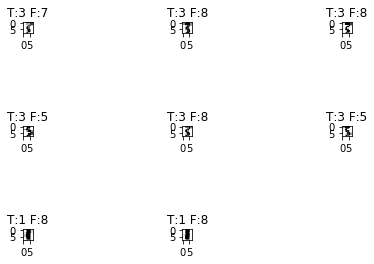

In [73]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

%matplotlib inline

X, Y = load_digits(return_X_y=True)
Y = Y.reshape((Y.shape[0],1))
Y1 = one_hot_encoding(Y)
print("X: ", X.shape, X[:5])
print("Y: ", Y.shape, Y[:5])
print("Y1: ", Y1.shape, Y1[:5])

X_train, Y_train = X[:-100], Y1[:-100]
X_test, Y_test = X[-100:], Y1[-100:]

model = Model(Adam(0.01, p1=0.99), CrossEntropyLoss())
model.add_layer(DenseLayer("L1", 64, 10))
# model.add_layer(BatchNormLayer("BN1", 10))
model.add_layer(SigmoidLayer("S1"))
# model.add_layer(DenseLayer("L2", 10, 10, Sigmoid()))
model.add_layer(SoftmaxLayer("softmax"))

model.train(X_train, Y_train, 50)
#model.evaluate(X_test, Y_test)

A = model.predict(X_test)
A1 = A.argmax(axis=1).reshape((A.shape[0],1))
Y1 = Y_test.argmax(axis=1).reshape((Y_test.shape[0],1))
C = (A1==Y1).astype(np.int)
print("A1:",A1[:5])
print("Y1:",Y1[:5])
print("C:",C[:5])
print("Accurace: %s" % (np.count_nonzero(C)/C.shape[0]))

fig=plt.figure(1)
falses = np.where(C==False)[0]
m = 3
n = (falses.shape[0]/3)+1
i=0
for f in falses:
    i = i+1
    imageplot = plt.subplot(m, n, i)    
    plt.imshow(X_test[f].reshape((8,8)), cmap='binary', vmax=16, vmin=0)
    imageplot.set_title("T:%d F:%d" % (Y1[f][0], A1[f][0]))

plt.subplots_adjust(wspace = 9, hspace = 9)
plt.show()    

In [77]:
from tensorflow.python.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print("Y_train: ", Y_train.shape, Y_train[:5])
Y_train = Y_train.reshape((60000,1))
Y_test = Y_test.reshape((10000,1))
Y_train = one_hot_encoding(Y_train)
Y_test = one_hot_encoding(Y_test)

print("X_train: ", X_train.shape, X_train[:2])
print("Y_train: ", Y_train.shape, Y_train[:2])

model = Model(AdaGrad(0.01), SoftmaxCrossEntropyLoss())
model.add_layer(DenseLayer("L1", 784, 32))
# model.add_layer(BatchNormLayer("BN1", 64))
model.add_layer(LeakyReluLayer("Relu1"))
model.add_layer(DenseLayer("L2", 32, 16))
model.add_layer(LeakyReluLayer("Relu2"))
model.add_layer(DenseLayer("L3", 16, 10))
model.add_layer(LeakyReluLayer("Relu3"))
# model.add_layer(SoftmaxLayer("softmax"))

model.train(X_train, Y_train, 100, batch=128)
model.evaluate(X_test, Y_test)

Y_train:  (60000,) [5 0 4 1 9]
X_train:  (60000, 784) [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Y_train:  (60000, 10) [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
loss for 0: 2.30258508704
loss for 0: 2.30257773421
loss for 0: 2.30258443526
loss for 0: 2.30251931763
loss for 0: 2.30246815199
loss for 0: 2.30268761824
loss for 0: 2.30234537191
loss for 0: 2.30238403464
loss for 0: 2.30244732596
loss for 0: 2.30226129858
loss for 0: 2.30269318057
loss for 0: 2.30235695604
loss for 0: 2.30218533158
loss for 0: 2.30191159891
loss for 0: 2.3018691024
loss for 0: 2.30172903504
loss for 0: 2.30139965454
loss for 0: 2.30144531274
loss for 0: 2.30218727852
loss for 0: 2.30094248927
loss for 0: 2.3013917062
loss for 0: 2.30263941435
loss for 0: 2.30104486105
loss for 0: 2.30179623605
loss for 0: 2.30147529986
loss for 0: 2.30128010018
loss for 0: 2.30107450154
loss for 0: 2.30102163523
loss for 0: 2.29968692682
loss for 0: 2.300996

loss for 0: 2.20580787735
loss for 0: 2.2260783618
loss for 0: 2.23799278493
loss for 0: 2.22489593006
loss for 0: 2.2034470361
loss for 0: 2.23257600348
loss for 0: 2.21095647585
loss for 0: 2.21731509459
loss for 0: 2.217341552
loss for 0: 2.22478538819
loss for 0: 2.21189573888
loss for 0: 2.22589622536
loss for 0: 2.21846499151
loss for 0: 2.22782597766
loss for 0: 2.20289748311
loss for 0: 2.21232399286
loss for 0: 2.22842263964
loss for 0: 2.21316369872
loss for 0: 2.23201964428
loss for 0: 2.23208379578
loss for 0: 2.20504020348
loss for 0: 2.22234243885
loss for 0: 2.20321162374
loss for 0: 2.1979216835
loss for 0: 2.22488716204
loss for 0: 2.22827416188
loss for 0: 2.21552532766
loss for 0: 2.20232902692
loss for 0: 2.23722617612
loss for 0: 2.23951670939
loss for 0: 2.21178884586
loss for 0: 2.2106348171
loss for 0: 2.22038889581
loss for 0: 2.23101395703
loss for 0: 2.2111870971
loss for 0: 2.18914382811
loss for 0: 2.2087925984
loss for 0: 2.20424800079
loss for 0: 2.213144

loss for 1: 2.20306352442
loss for 1: 2.20429152712
loss for 1: 2.18375518003
loss for 1: 2.1763159727
loss for 1: 2.21502822831
loss for 1: 2.17563167547
loss for 1: 2.20451198765
loss for 1: 2.20806587109
loss for 1: 2.17627509167
loss for 1: 2.22039276874
loss for 1: 2.19842488088
loss for 1: 2.20261066911
loss for 1: 2.19662476697
loss for 1: 2.21181506678
loss for 1: 2.1670653591
loss for 1: 2.22287638331
loss for 1: 2.21508210377
loss for 1: 2.19228867074
loss for 1: 2.20140820409
loss for 1: 2.2040546384
loss for 1: 2.20050754324
loss for 1: 2.21918215841
loss for 1: 2.22914047962
loss for 1: 2.19452970756
loss for 1: 2.1937844914
loss for 1: 2.20596360776
loss for 1: 2.19832341316
loss for 1: 2.20537656792
loss for 1: 2.18648390534
loss for 1: 2.17669409988
loss for 1: 2.19013149894
loss for 1: 2.20369136864
loss for 1: 2.19269386208
loss for 1: 2.19388684825
loss for 1: 2.18581008916
loss for 1: 2.18042875108
loss for 1: 2.20746697959
loss for 1: 2.21321155999
loss for 1: 2.21

loss for 2: 2.19722720974
loss for 2: 2.14891567947
loss for 2: 2.14319331908
loss for 2: 2.14858612147
loss for 2: 2.14129954497
loss for 2: 2.14697615383
loss for 2: 2.16050980553
loss for 2: 2.17342818869
loss for 2: 2.1578279467
loss for 2: 2.16237769915
loss for 2: 2.13942221471
loss for 2: 2.16462515263
loss for 2: 2.14804176839
loss for 2: 2.15629017309
loss for 2: 2.12915841835
loss for 2: 2.16172516643
loss for 2: 2.17850417015
loss for 2: 2.1903341561
loss for 2: 2.15085536417
loss for 2: 2.18323818867
loss for 2: 2.16517623266
loss for 2: 2.15444059777
loss for 2: 2.14878093006
loss for 2: 2.12059849583
loss for 2: 2.12294414333
loss for 2: 2.17544821707
loss for 2: 2.16714742422
loss for 2: 2.14652599092
loss for 2: 2.14344901512
loss for 2: 2.15228804205
loss for 2: 2.15122749534
loss for 2: 2.16132417341
loss for 2: 2.13334502549
loss for 2: 2.15029834643
loss for 2: 2.16707507237
loss for 2: 2.18079485126
loss for 2: 2.1854697392
loss for 2: 2.17141646141
loss for 2: 2.1

loss for 3: 2.11821825975
loss for 3: 2.08989141767
loss for 3: 2.11479753277
loss for 3: 2.08760852355
loss for 3: 2.14922960326
loss for 3: 2.07935619027
loss for 3: 2.12306137665
loss for 3: 2.09475165157
loss for 3: 2.13804768054
loss for 3: 2.11550359234
loss for 3: 2.08422002027
loss for 3: 2.1125829881
loss for 3: 2.11052513413
loss for 3: 2.06947228019
loss for 3: 2.10755597085
loss for 3: 2.11843204117
loss for 3: 2.12421200898
loss for 3: 2.12645344166
loss for 3: 2.09529364315
loss for 3: 2.11445080375
loss for 3: 2.10859141076
loss for 3: 2.10179445109
loss for 3: 2.11569944557
loss for 3: 2.11608220315
loss for 3: 2.0872132771
loss for 3: 2.10440879913
loss for 3: 2.11894986308
loss for 3: 2.11581890055
loss for 3: 2.09243967504
loss for 3: 2.09240908696
loss for 3: 2.09714637425
loss for 3: 2.13169089799
loss for 3: 2.11076595844
loss for 3: 2.08201303532
loss for 3: 2.066294088
loss for 3: 2.10194638189
loss for 3: 2.09326747611
loss for 3: 2.09505565864
loss for 3: 2.09

loss for 4: 1.97816817383
loss for 4: 2.020761214
loss for 4: 2.04090653993
loss for 4: 2.04098844828
loss for 4: 2.05146512002
loss for 4: 2.06685020862
loss for 4: 2.02178602681
loss for 4: 2.01597736607
loss for 4: 2.02317876103
loss for 4: 2.02087717928
loss for 4: 2.03350129612
loss for 4: 1.9938746436
loss for 4: 2.00422256876
loss for 4: 2.00902128037
loss for 4: 1.98650137025
loss for 4: 2.06585924879
loss for 4: 1.98947267722
loss for 4: 2.02246345999
loss for 4: 2.00583957484
loss for 4: 1.99436476431
loss for 4: 2.03917780203
loss for 4: 2.06038038161
loss for 4: 2.02645353575
loss for 4: 1.98879893491
loss for 4: 2.00772551489
loss for 4: 1.97951814829
loss for 4: 2.02100030075
loss for 4: 2.05629145688
loss for 4: 2.06271085867
loss for 4: 2.04886106932
loss for 4: 2.00245872005
loss for 4: 1.96633477175
loss for 4: 2.00105512118
loss for 4: 2.04739155208
loss for 4: 2.02058193035
loss for 4: 2.01900179584
loss for 4: 2.01644222769
loss for 4: 1.98254195078
loss for 4: 2.0

loss for 5: 1.90859605236
loss for 5: 1.8206051755
loss for 5: 1.88321789922
loss for 5: 1.89610999211
loss for 5: 1.83509138143
loss for 5: 1.88066553246
loss for 5: 1.86702081394
loss for 5: 1.85291241657
loss for 5: 1.83800179684
loss for 5: 1.86436504627
loss for 5: 1.90230799407
loss for 5: 1.89403852576
loss for 5: 1.85252710286
loss for 5: 1.79127797143
loss for 5: 1.89149481716
loss for 5: 1.88559610659
loss for 5: 1.89252073486
loss for 5: 1.82384323798
loss for 5: 1.89101491738
loss for 5: 1.94792090297
loss for 5: 1.89929283351
loss for 5: 1.91329424739
loss for 5: 1.95931790162
loss for 5: 1.93160669314
loss for 5: 1.9302334064
loss for 5: 1.89254750777
loss for 5: 1.9142811375
loss for 5: 1.86439021982
loss for 5: 1.86700582964
loss for 5: 1.84794041337
loss for 5: 1.90911139001
loss for 5: 1.89864803235
loss for 5: 1.839343778
loss for 5: 1.88529793215
loss for 5: 1.89526269141
loss for 5: 1.92528313016
loss for 5: 1.82179657671
loss for 5: 1.89650546594
loss for 5: 1.901

loss for 5: 1.77396957904
loss for 5: 1.73427502274
loss for 5: 1.74511794274
loss for 5: 1.7283494945
loss for 5: 1.78605451195
loss for 5: 1.82655996228
loss for 5: 1.73577186976
loss for 5: 1.76202317361
loss for 5: 1.77028691424
loss for 5: 1.80168315774
loss for 5: 1.72134468489
loss for 5: 1.73346060488
loss for 5: 1.7533423939
loss for 5: 1.73800167678
loss for 5: 1.76638732704
loss for 5: 1.82451246583
loss for 5: 1.78984214361
loss for 5: 1.77652903253
loss for 5: 1.8028762854
loss for 5: 1.70589220768
loss for 5: 1.74373775195
loss for 5: 1.81884129979
loss for 5: 1.75775816905
loss for 5: 1.81882687041
loss for 5: 1.76742114155
loss for 5: 1.79051722947
loss for 5: 1.81738031115
loss for 5: 1.80743835447
loss for 5: 1.74434149877
loss for 5: 1.7583370081
loss for 5: 1.71269823795
loss for 5: 1.71823800887
loss for 5: 1.70493924923
loss for 5: 1.75104788292
loss for 5: 1.77795382292
loss for 5: 1.74652682318
loss for 5: 1.66893880806
loss for 5: 1.69444149449
loss for 5: 1.68

loss for 6: 1.65525554985
loss for 6: 1.67165286217
loss for 6: 1.66990463417
loss for 6: 1.70890252209
loss for 6: 1.75152418394
loss for 6: 1.75192022778
loss for 6: 1.75666448704
loss for 6: 1.72437928515
loss for 6: 1.72814750898
loss for 6: 1.69893660768
loss for 6: 1.69792998358
loss for 6: 1.72738988917
loss for 6: 1.76910043431
loss for 6: 1.71867685364
loss for 6: 1.73150314679
loss for 6: 1.67414208855
loss for 6: 1.72184765869
loss for 6: 1.75408338964
loss for 6: 1.71125098507
loss for 6: 1.73390049964
loss for 6: 1.76813734157
loss for 6: 1.78086369284
loss for 6: 1.72359746722
loss for 6: 1.7561928166
loss for 6: 1.7468465723
loss for 6: 1.66888701825
loss for 6: 1.6890583816
loss for 6: 1.66525184005
loss for 6: 1.65376133158
loss for 6: 1.68298427482
loss for 6: 1.71840585563
loss for 6: 1.78448163128
loss for 6: 1.70582183669
loss for 6: 1.74214709792
loss for 6: 1.67296494811
loss for 6: 1.63358957738
loss for 6: 1.7258728486
loss for 6: 1.6701404001
loss for 6: 1.636

loss for 7: 1.69775653643
loss for 7: 1.68389858089
loss for 7: 1.66238899086
loss for 7: 1.72442816965
loss for 7: 1.7062357224
loss for 7: 1.73360499035
loss for 7: 1.64614435908
loss for 7: 1.68072090325
loss for 7: 1.6650704966
loss for 7: 1.63841705938
loss for 7: 1.66065188557
loss for 7: 1.67344331161
loss for 7: 1.68648920227
loss for 7: 1.69918284847
loss for 7: 1.68461881883
loss for 7: 1.64908051063
loss for 7: 1.58844776052
loss for 7: 1.64110023837
loss for 7: 1.67526547975
loss for 7: 1.6167737922
loss for 7: 1.6634732228
loss for 7: 1.69212858461
loss for 7: 1.68369845059
loss for 7: 1.70779901585
loss for 7: 1.72970607437
loss for 7: 1.62772601353
loss for 7: 1.68387069792
loss for 7: 1.69219702093
loss for 7: 1.63322193902
loss for 7: 1.66330598019
loss for 7: 1.6862746503
loss for 7: 1.6381140237
loss for 7: 1.70811623421
loss for 7: 1.75940596918
loss for 7: 1.64104943377
loss for 7: 1.61159242089
loss for 7: 1.68250675116
loss for 7: 1.64664684001
loss for 7: 1.5922

loss for 8: 1.66327380715
loss for 8: 1.67296830024
loss for 8: 1.57090653243
loss for 8: 1.611477892
loss for 8: 1.62988499524
loss for 8: 1.64093573621
loss for 8: 1.7496611401
loss for 8: 1.65041750944
loss for 8: 1.62791871688
loss for 8: 1.66410438544
loss for 8: 1.65031630088
loss for 8: 1.69757744001
loss for 8: 1.67946533328
loss for 8: 1.52938910376
loss for 8: 1.55832843001
loss for 8: 1.68578380645
loss for 8: 1.71347436208
loss for 8: 1.65390074269
loss for 8: 1.73202627108
loss for 8: 1.68925954442
loss for 8: 1.63690861369
loss for 8: 1.6166249674
loss for 8: 1.57410669538
loss for 8: 1.63351865803
loss for 8: 1.61771722205
loss for 8: 1.63206962075
loss for 8: 1.6642493115
loss for 8: 1.68753277805
loss for 8: 1.69622212329
loss for 8: 1.66577668351
loss for 8: 1.64767058778
loss for 8: 1.62973278772
loss for 8: 1.69705061371
loss for 8: 1.62531474342
loss for 8: 1.66662577172
loss for 8: 1.67094057642
loss for 8: 1.68410003568
loss for 8: 1.69877979076
loss for 8: 1.640

loss for 9: 1.67084585118
loss for 9: 1.71075779786
loss for 9: 1.57599308626
loss for 9: 1.66410491266
loss for 9: 1.6404894249
loss for 9: 1.63646445362
loss for 9: 1.63172946528
loss for 9: 1.59002925822
loss for 9: 1.59347050758
loss for 9: 1.59128071955
loss for 9: 1.63573598184
loss for 9: 1.66424376864
loss for 9: 1.62534189834
loss for 9: 1.56121626191
loss for 9: 1.56087412937
loss for 9: 1.63301623457
loss for 9: 1.59125916865
loss for 9: 1.59513081036
loss for 9: 1.60259197489
loss for 9: 1.63836784083
loss for 9: 1.60756971281
loss for 9: 1.64126956495
loss for 9: 1.70560622343
loss for 9: 1.67987832167
loss for 9: 1.6516786445
loss for 9: 1.60418523391
loss for 9: 1.58307603569
loss for 9: 1.62219408279
loss for 9: 1.63730747343
loss for 9: 1.6584229825
loss for 9: 1.66765275967
loss for 9: 1.66338914706
loss for 9: 1.65829160698
loss for 9: 1.68931758855
loss for 9: 1.66895964146
loss for 9: 1.62347796256
loss for 9: 1.61230924242
loss for 9: 1.56352703756
loss for 9: 1.6

loss for 9: 1.63035007645
loss for 9: 1.61071334335
loss for 9: 1.55454336427
loss for 9: 1.54843836549
loss for 9: 1.55695647415
loss for 9: 1.60058563368
loss for 9: 1.61837133055
loss for 9: 1.60907218939
loss for 9: 1.51110885468
loss for 9: 1.53960490064
loss for 9: 1.51986365978
loss for 9: 1.59935413137
loss for 9: 1.51420131743
loss for 9: 1.60510385979
loss for 9: 1.62786163857
loss for 9: 1.49410265882
loss for 9: 1.67493219781
loss for 10: 1.59669803804
loss for 10: 1.63389497985
loss for 10: 1.57710707181
loss for 10: 1.63184899694
loss for 10: 1.67377809338
loss for 10: 1.61096737415
loss for 10: 1.64279592628
loss for 10: 1.63814189194
loss for 10: 1.75038944176
loss for 10: 1.59533385241
loss for 10: 1.61639920022
loss for 10: 1.62609010457
loss for 10: 1.63730170036
loss for 10: 1.58146597661
loss for 10: 1.61832938273
loss for 10: 1.59328325202
loss for 10: 1.55016178287
loss for 10: 1.60560572286
loss for 10: 1.62047318454
loss for 10: 1.61233469287
loss for 10: 1.593

loss for 10: 1.63495543673
loss for 10: 1.62363584758
loss for 10: 1.57192282077
loss for 10: 1.64511089428
loss for 10: 1.62058266248
loss for 10: 1.68035855619
loss for 10: 1.69120413636
loss for 10: 1.66877494243
loss for 10: 1.64304021048
loss for 10: 1.65306712658
loss for 10: 1.59537077186
loss for 10: 1.58706669183
loss for 10: 1.64597207581
loss for 10: 1.65299631045
loss for 10: 1.62359152793
loss for 10: 1.57552183081
loss for 10: 1.57853937779
loss for 10: 1.57674375174
loss for 10: 1.6840180347
loss for 10: 1.69374389585
loss for 10: 1.62351165253
loss for 10: 1.55106021995
loss for 10: 1.58363883825
loss for 10: 1.57848953092
loss for 10: 1.60031067729
loss for 10: 1.63794442372
loss for 10: 1.65778902174
loss for 10: 1.65247895259
loss for 10: 1.6378267227
loss for 10: 1.63305273547
loss for 10: 1.61277051628
loss for 10: 1.59902798212
loss for 10: 1.63146426062
loss for 10: 1.67836263659
loss for 10: 1.62531531679
loss for 10: 1.64025638038
loss for 10: 1.59888039752
los

loss for 11: 1.51099222511
loss for 11: 1.50050147543
loss for 11: 1.58501268328
loss for 11: 1.60224106383
loss for 11: 1.57355554853
loss for 11: 1.60756944725
loss for 11: 1.61031234306
loss for 11: 1.57782477484
loss for 11: 1.6129156246
loss for 11: 1.70016664188
loss for 11: 1.64771536658
loss for 11: 1.56465048901
loss for 11: 1.57233313339
loss for 11: 1.63625463819
loss for 11: 1.67015306376
loss for 11: 1.73564877435
loss for 11: 1.68045595781
loss for 11: 1.69920500362
loss for 11: 1.59875179006
loss for 11: 1.60287121614
loss for 11: 1.66314956459
loss for 11: 1.71229165325
loss for 11: 1.62852693182
loss for 11: 1.64905505079
loss for 11: 1.63883168198
loss for 11: 1.60798643231
loss for 11: 1.6916597713
loss for 11: 1.65857321468
loss for 11: 1.64244146306
loss for 11: 1.70814253052
loss for 11: 1.64239613363
loss for 11: 1.62632583521
loss for 11: 1.58972098077
loss for 11: 1.65162120746
loss for 11: 1.64633370506
loss for 11: 1.65870916149
loss for 11: 1.58955291135
los

loss for 12: 1.59671471841
loss for 12: 1.6165156206
loss for 12: 1.61820946554
loss for 12: 1.61947532357
loss for 12: 1.53388998438
loss for 12: 1.57546438817
loss for 12: 1.58663949558
loss for 12: 1.59194428228
loss for 12: 1.6896008636
loss for 12: 1.60335043863
loss for 12: 1.58477554823
loss for 12: 1.62493220671
loss for 12: 1.60494208297
loss for 12: 1.64798151636
loss for 12: 1.63506301447
loss for 12: 1.49160638452
loss for 12: 1.5195925188
loss for 12: 1.62635511245
loss for 12: 1.66872166281
loss for 12: 1.60508438341
loss for 12: 1.68701876223
loss for 12: 1.65718565495
loss for 12: 1.60416215976
loss for 12: 1.56911404022
loss for 12: 1.53230857005
loss for 12: 1.59269549531
loss for 12: 1.56783956783
loss for 12: 1.58566254507
loss for 12: 1.60908128777
loss for 12: 1.63740255307
loss for 12: 1.65161535334
loss for 12: 1.62296421086
loss for 12: 1.60724039415
loss for 12: 1.58145373756
loss for 12: 1.64738504121
loss for 12: 1.5804379315
loss for 12: 1.62274627016
loss 

loss for 12: 1.49408099321
loss for 12: 1.51678568451
loss for 12: 1.50251675964
loss for 12: 1.58558360624
loss for 12: 1.49290432259
loss for 12: 1.58787195451
loss for 12: 1.61448904649
loss for 12: 1.47701818539
loss for 12: 1.64887274701
loss for 13: 1.57608861586
loss for 13: 1.61544055827
loss for 13: 1.55461119475
loss for 13: 1.60696104235
loss for 13: 1.6510264677
loss for 13: 1.58638464859
loss for 13: 1.61918603923
loss for 13: 1.62069497653
loss for 13: 1.72945260742
loss for 13: 1.5728257813
loss for 13: 1.59567317828
loss for 13: 1.59736566442
loss for 13: 1.61068532991
loss for 13: 1.5681329076
loss for 13: 1.59457042223
loss for 13: 1.57138281079
loss for 13: 1.53525085845
loss for 13: 1.58623766501
loss for 13: 1.59593088148
loss for 13: 1.58912249741
loss for 13: 1.57830983783
loss for 13: 1.60172067035
loss for 13: 1.56634997001
loss for 13: 1.63064853974
loss for 13: 1.60645962481
loss for 13: 1.59936596455
loss for 13: 1.57961815385
loss for 13: 1.62061948408
loss

loss for 13: 1.61195811625
loss for 13: 1.61411550519
loss for 13: 1.59445760806
loss for 13: 1.649078965
loss for 13: 1.59658417026
loss for 13: 1.58483692076
loss for 13: 1.58891083279
loss for 13: 1.55357162344
loss for 13: 1.58490234416
loss for 13: 1.5336365154
loss for 13: 1.53554356936
loss for 13: 1.67257983931
loss for 13: 1.63899313345
loss for 13: 1.56244769023
loss for 13: 1.66307643304
loss for 13: 1.64466094369
loss for 13: 1.61531146941
loss for 13: 1.58378950876
loss for 13: 1.64357878024
loss for 13: 1.60479982414
loss for 13: 1.59645189231
loss for 13: 1.61685878272
loss for 13: 1.61026417092
loss for 13: 1.55250461475
loss for 13: 1.625061796
loss for 13: 1.60138399003
loss for 13: 1.66027587251
loss for 13: 1.66511313515
loss for 13: 1.64489884623
loss for 13: 1.62444683419
loss for 13: 1.63232230828
loss for 13: 1.5768315055
loss for 13: 1.57240170658
loss for 13: 1.62082984449
loss for 13: 1.63653128229
loss for 13: 1.60347564318
loss for 13: 1.55422369047
loss fo

loss for 14: 1.66366255361
loss for 14: 1.67515249474
loss for 14: 1.58108574035
loss for 14: 1.58106260362
loss for 14: 1.64515439158
loss for 14: 1.69330966284
loss for 14: 1.6092732847
loss for 14: 1.6311380864
loss for 14: 1.62401911577
loss for 14: 1.59313063877
loss for 14: 1.67308985502
loss for 14: 1.64038198146
loss for 14: 1.63035106294
loss for 14: 1.69560495738
loss for 14: 1.62318589357
loss for 14: 1.61073348375
loss for 14: 1.57642670281
loss for 14: 1.63463498126
loss for 14: 1.62995125536
loss for 14: 1.63740048049
loss for 14: 1.57280700424
loss for 14: 1.60660878308
loss for 14: 1.5927939985
loss for 14: 1.5569205286
loss for 14: 1.57801890126
loss for 14: 1.59745385874
loss for 14: 1.60578410239
loss for 14: 1.62529358334
loss for 14: 1.61694183377
loss for 14: 1.57173326779
loss for 14: 1.50931907451
loss for 14: 1.55513464228
loss for 14: 1.58983445783
loss for 14: 1.54226446993
loss for 14: 1.58176479854
loss for 14: 1.61527798948
loss for 14: 1.60638627994
loss 

loss for 15: 1.62136154495
loss for 15: 1.48386883537
loss for 15: 1.51068693335
loss for 15: 1.60772563158
loss for 15: 1.65369263105
loss for 15: 1.58675224327
loss for 15: 1.66819240927
loss for 15: 1.64491236172
loss for 15: 1.59105589949
loss for 15: 1.55358501878
loss for 15: 1.5193159639
loss for 15: 1.57751812985
loss for 15: 1.55525721198
loss for 15: 1.56769333205
loss for 15: 1.58986198408
loss for 15: 1.61986848468
loss for 15: 1.63546464093
loss for 15: 1.60979271058
loss for 15: 1.59526769687
loss for 15: 1.56497272699
loss for 15: 1.63282496636
loss for 15: 1.56531229208
loss for 15: 1.60622026522
loss for 15: 1.62936742975
loss for 15: 1.62883149517
loss for 15: 1.64560271045
loss for 15: 1.60079993316
loss for 15: 1.60586531779
loss for 15: 1.57683781605
loss for 15: 1.47964762984
loss for 15: 1.55156367158
loss for 15: 1.5629691376
loss for 15: 1.62529151426
loss for 15: 1.61586666589
loss for 15: 1.56349979411
loss for 15: 1.54762560055
loss for 15: 1.6189444636
loss

loss for 16: 1.5732003632
loss for 16: 1.60708536674
loss for 16: 1.60751430323
loss for 16: 1.71625563756
loss for 16: 1.56218787968
loss for 16: 1.58122461279
loss for 16: 1.58036692332
loss for 16: 1.59451049
loss for 16: 1.56241145096
loss for 16: 1.58014057175
loss for 16: 1.55680343048
loss for 16: 1.52706879407
loss for 16: 1.57461864589
loss for 16: 1.5810332395
loss for 16: 1.57636627013
loss for 16: 1.57157630291
loss for 16: 1.5862759729
loss for 16: 1.55654791007
loss for 16: 1.61643201921
loss for 16: 1.59064489954
loss for 16: 1.58636180616
loss for 16: 1.56930488558
loss for 16: 1.60596531256
loss for 16: 1.55136270987
loss for 16: 1.6017895535
loss for 16: 1.55706694723
loss for 16: 1.56120073297
loss for 16: 1.60668829287
loss for 16: 1.58657270168
loss for 16: 1.60705830716
loss for 16: 1.5410733676
loss for 16: 1.55452363586
loss for 16: 1.59022688181
loss for 16: 1.54569092253
loss for 16: 1.59360059688
loss for 16: 1.60591104033
loss for 16: 1.59852272851
loss for 

loss for 16: 1.63009763501
loss for 16: 1.60493569952
loss for 16: 1.57286708839
loss for 16: 1.63087452592
loss for 16: 1.59164155777
loss for 16: 1.58062793642
loss for 16: 1.6037638381
loss for 16: 1.60111302187
loss for 16: 1.53895433437
loss for 16: 1.61169232875
loss for 16: 1.58742762687
loss for 16: 1.64482482943
loss for 16: 1.64820276311
loss for 16: 1.62924819431
loss for 16: 1.6134055591
loss for 16: 1.6184023358
loss for 16: 1.56391965433
loss for 16: 1.56210071548
loss for 16: 1.60491520803
loss for 16: 1.62326643772
loss for 16: 1.59302983959
loss for 16: 1.54378894752
loss for 16: 1.55877936602
loss for 16: 1.55314704828
loss for 16: 1.6573484452
loss for 16: 1.65807456914
loss for 16: 1.58789671281
loss for 16: 1.5185529182
loss for 16: 1.54992832875
loss for 16: 1.55371167976
loss for 16: 1.56083106337
loss for 16: 1.60149899577
loss for 16: 1.63550612726
loss for 16: 1.62935402236
loss for 16: 1.61285405326
loss for 16: 1.6084438625
loss for 16: 1.58665752102
loss fo

loss for 17: 1.54311671453
loss for 17: 1.59275931737
loss for 17: 1.61247114696
loss for 17: 1.56179798077
loss for 17: 1.53074940865
loss for 17: 1.5333781303
loss for 17: 1.51798954365
loss for 17: 1.52710751253
loss for 17: 1.56744277236
loss for 17: 1.59527207491
loss for 17: 1.60010866257
loss for 17: 1.59239542289
loss for 17: 1.51739458452
loss for 17: 1.55916171927
loss for 17: 1.57173692207
loss for 17: 1.57588323617
loss for 17: 1.65930642213
loss for 17: 1.58189961988
loss for 17: 1.56507894369
loss for 17: 1.60543503906
loss for 17: 1.58543131852
loss for 17: 1.62247823942
loss for 17: 1.61452175929
loss for 17: 1.48145410568
loss for 17: 1.50803496322
loss for 17: 1.59960473526
loss for 17: 1.64701289544
loss for 17: 1.57905986718
loss for 17: 1.65932620368
loss for 17: 1.63914338834
loss for 17: 1.58397232183
loss for 17: 1.54592794338
loss for 17: 1.51322427911
loss for 17: 1.57065030042
loss for 17: 1.55006494304
loss for 17: 1.56115268887
loss for 17: 1.58169626483
lo

loss for 18: 1.58125197785
loss for 18: 1.53365785367
loss for 18: 1.53463812337
loss for 18: 1.54538301579
loss for 18: 1.5932420254
loss for 18: 1.55746894666
loss for 18: 1.58147371366
loss for 18: 1.63315939066
loss for 18: 1.60832289653
loss for 18: 1.58862798937
loss for 18: 1.55378194582
loss for 18: 1.53750829406
loss for 18: 1.57568935797
loss for 18: 1.58223116255
loss for 18: 1.60835453124
loss for 18: 1.61420116981
loss for 18: 1.60033727966
loss for 18: 1.59501224933
loss for 18: 1.62983104277
loss for 18: 1.60944133441
loss for 18: 1.56269275835
loss for 18: 1.54695113501
loss for 18: 1.52999003802
loss for 18: 1.60153532123
loss for 18: 1.63381545753
loss for 18: 1.6058138079
loss for 18: 1.60728285645
loss for 18: 1.58156187525
loss for 18: 1.58939881759
loss for 18: 1.63924652358
loss for 18: 1.66419952429
loss for 18: 1.67709987214
loss for 18: 1.70076700492
loss for 18: 1.56801051676
loss for 18: 1.55400298221
loss for 18: 1.63108004621
loss for 18: 1.59632689248
los

loss for 19: 1.56529800941
loss for 19: 1.57495619399
loss for 19: 1.54850864911
loss for 19: 1.60655648921
loss for 19: 1.57936515402
loss for 19: 1.57663638053
loss for 19: 1.56047203883
loss for 19: 1.59487046625
loss for 19: 1.54406403279
loss for 19: 1.59079065905
loss for 19: 1.54769829602
loss for 19: 1.55423856772
loss for 19: 1.59600613683
loss for 19: 1.57871005733
loss for 19: 1.59847586733
loss for 19: 1.53370207965
loss for 19: 1.54800628221
loss for 19: 1.58147373076
loss for 19: 1.53936331327
loss for 19: 1.58628162414
loss for 19: 1.59937214048
loss for 19: 1.59244682246
loss for 19: 1.49545665988
loss for 19: 1.56454420991
loss for 19: 1.57794174812
loss for 19: 1.60280458831
loss for 19: 1.55038692952
loss for 19: 1.49116753955
loss for 19: 1.51849250704
loss for 19: 1.54659274006
loss for 19: 1.56059292036
loss for 19: 1.53814040113
loss for 19: 1.59688891501
loss for 19: 1.66586373937
loss for 19: 1.628503362
loss for 19: 1.59263553771
loss for 19: 1.67600479548
los

loss for 19: 1.60906509169
loss for 19: 1.55580795993
loss for 19: 1.55597830311
loss for 19: 1.59475712131
loss for 19: 1.6128707834
loss for 19: 1.58708428882
loss for 19: 1.53853832869
loss for 19: 1.55524841158
loss for 19: 1.54814644208
loss for 19: 1.64688562843
loss for 19: 1.64807338891
loss for 19: 1.57658725032
loss for 19: 1.50970580418
loss for 19: 1.54095995219
loss for 19: 1.54614286355
loss for 19: 1.55053105471
loss for 19: 1.58935653186
loss for 19: 1.62719023306
loss for 19: 1.6218138551
loss for 19: 1.6046014992
loss for 19: 1.60044172141
loss for 19: 1.58015245197
loss for 19: 1.55711170086
loss for 19: 1.5941742833
loss for 19: 1.63158375453
loss for 19: 1.59205826518
loss for 19: 1.5977248368
loss for 19: 1.56911194941
loss for 19: 1.57700018991
loss for 19: 1.64601885245
loss for 19: 1.58260502444
loss for 19: 1.59741412251
loss for 19: 1.62210491451
loss for 19: 1.66613524701
loss for 19: 1.61112230064
loss for 19: 1.647008521
loss for 19: 1.63208516116
loss for

loss for 20: 1.56818950288
loss for 20: 1.64439223133
loss for 20: 1.5743359366
loss for 20: 1.55708132699
loss for 20: 1.59599364643
loss for 20: 1.5799272848
loss for 20: 1.61034463661
loss for 20: 1.60614310603
loss for 20: 1.47817731873
loss for 20: 1.5057255718
loss for 20: 1.590926911
loss for 20: 1.63810076919
loss for 20: 1.56998696463
loss for 20: 1.64835068165
loss for 20: 1.63161090633
loss for 20: 1.57597988994
loss for 20: 1.53726772113
loss for 20: 1.50569152571
loss for 20: 1.56156022297
loss for 20: 1.5433689489
loss for 20: 1.55401633819
loss for 20: 1.57138593214
loss for 20: 1.60379374548
loss for 20: 1.61958988068
loss for 20: 1.59696988167
loss for 20: 1.58106295458
loss for 20: 1.54872870907
loss for 20: 1.61520520395
loss for 20: 1.54839565343
loss for 20: 1.58861446184
loss for 20: 1.61683906378
loss for 20: 1.61256665093
loss for 20: 1.6253100074
loss for 20: 1.58588964769
loss for 20: 1.59652543204
loss for 20: 1.56791239669
loss for 20: 1.47128670431
loss for

loss for 21: 1.60981046771
loss for 21: 1.59367219908
loss for 21: 1.5851603663
loss for 21: 1.62080774566
loss for 21: 1.60158589318
loss for 21: 1.5549173802
loss for 21: 1.53942794414
loss for 21: 1.526648578
loss for 21: 1.59464349267
loss for 21: 1.6253011862
loss for 21: 1.59648757802
loss for 21: 1.59680015838
loss for 21: 1.57128874292
loss for 21: 1.58115050014
loss for 21: 1.62858757651
loss for 21: 1.65468647633
loss for 21: 1.66479911181
loss for 21: 1.69024414642
loss for 21: 1.55885050637
loss for 21: 1.54652274312
loss for 21: 1.62177337902
loss for 21: 1.59003364787
loss for 21: 1.60801961432
loss for 21: 1.57660203359
loss for 21: 1.60121069571
loss for 21: 1.65630236889
loss for 21: 1.60549888649
loss for 21: 1.59293558151
loss for 21: 1.52138358514
loss for 21: 1.5416196294
loss for 21: 1.56146034818
loss for 21: 1.56931042995
loss for 21: 1.59737419369
loss for 21: 1.6361160779
loss for 21: 1.61316668245
loss for 21: 1.57669410425
loss for 21: 1.57652669205
loss for

loss for 21: 1.55368544589
loss for 21: 1.55372102799
loss for 21: 1.57752196193
loss for 21: 1.5925202588
loss for 21: 1.6798895243
loss for 21: 1.57435313983
loss for 21: 1.52909421568
loss for 21: 1.51504500767
loss for 21: 1.60619896054
loss for 21: 1.62078299088
loss for 21: 1.66484215569
loss for 21: 1.57522080955
loss for 21: 1.56751503527
loss for 21: 1.54810207164
loss for 21: 1.55097563426
loss for 21: 1.59700272047
loss for 21: 1.5993060242
loss for 21: 1.57780363758
loss for 21: 1.59819153504
loss for 21: 1.58142075101
loss for 21: 1.56008079613
loss for 21: 1.55889962528
loss for 21: 1.53586297222
loss for 21: 1.53527943644
loss for 21: 1.5094025411
loss for 21: 1.59994863554
loss for 21: 1.63074720097
loss for 21: 1.53642309907
loss for 21: 1.53541576144
loss for 21: 1.56150008729
loss for 21: 1.55826447839
loss for 21: 1.50230087616
loss for 21: 1.5290152002
loss for 21: 1.55489203054
loss for 21: 1.51407278535
loss for 21: 1.56204436884
loss for 21: 1.58878694061
loss f

loss for 22: 1.56754394564
loss for 22: 1.5030948232
loss for 22: 1.53510462147
loss for 22: 1.54161719409
loss for 22: 1.54149353223
loss for 22: 1.57913097777
loss for 22: 1.61978355846
loss for 22: 1.61551343363
loss for 22: 1.59598579973
loss for 22: 1.59207974946
loss for 22: 1.57476573163
loss for 22: 1.54851355257
loss for 22: 1.5881594782
loss for 22: 1.6239225845
loss for 22: 1.58440426648
loss for 22: 1.58905999453
loss for 22: 1.56272861645
loss for 22: 1.5680552213
loss for 22: 1.63897006111
loss for 22: 1.57748085277
loss for 22: 1.59029135263
loss for 22: 1.61621622323
loss for 22: 1.65887609683
loss for 22: 1.6033327165
loss for 22: 1.63814190905
loss for 22: 1.62540361339
loss for 22: 1.53607478536
loss for 22: 1.53869450387
loss for 22: 1.54091835726
loss for 22: 1.54415443149
loss for 22: 1.52987256737
loss for 22: 1.58033062554
loss for 22: 1.64466728841
loss for 22: 1.58230636615
loss for 22: 1.60791401219
loss for 22: 1.55028131051
loss for 22: 1.52251712421
loss f

loss for 23: 1.57676126133
loss for 23: 1.6017056079
loss for 23: 1.54871519683
loss for 23: 1.57178278289
loss for 23: 1.58889615038
loss for 23: 1.55070404432
loss for 23: 1.61415301797
loss for 23: 1.64926596391
loss for 23: 1.54413529016
loss for 23: 1.52885192808
loss for 23: 1.58865073481
loss for 23: 1.55239605671
loss for 23: 1.4887031276
loss for 23: 1.54491003791
loss for 23: 1.54164150431
loss for 23: 1.59220612094
loss for 23: 1.55663348866
loss for 23: 1.59494832222
loss for 23: 1.63125285349
loss for 23: 1.6296096985
loss for 23: 1.60370991337
loss for 23: 1.57307893092
loss for 23: 1.58425001132
loss for 23: 1.57645082476
loss for 23: 1.56058572331
loss for 23: 1.61207699331
loss for 23: 1.57217678688
loss for 23: 1.55471858797
loss for 23: 1.56429731837
loss for 23: 1.52648947816
loss for 23: 1.56009712548
loss for 23: 1.51137385844
loss for 23: 1.52065283727
loss for 23: 1.6458509559
loss for 23: 1.61003447729
loss for 23: 1.534984217
loss for 23: 1.61989638575
loss fo

loss for 24: 1.5623666785
loss for 24: 1.5888159224
loss for 24: 1.63039724287
loss for 24: 1.57324177474
loss for 24: 1.58594475119
loss for 24: 1.55104233848
loss for 24: 1.60799265819
loss for 24: 1.61445200297
loss for 24: 1.4839967597
loss for 24: 1.48473131927
loss for 24: 1.54171585277
loss for 24: 1.57072960921
loss for 24: 1.54000196103
loss for 24: 1.55649166584
loss for 24: 1.55791957803
loss for 24: 1.54210840941
loss for 24: 1.57086925484
loss for 24: 1.6514458229
loss for 24: 1.59619369991
loss for 24: 1.53223340874
loss for 24: 1.52376606603
loss for 24: 1.58700401978
loss for 24: 1.61493831296
loss for 24: 1.67388089333
loss for 24: 1.63603233296
loss for 24: 1.63776098164
loss for 24: 1.55334167157
loss for 24: 1.55236262716
loss for 24: 1.60860749415
loss for 24: 1.65355633878
loss for 24: 1.57995221648
loss for 24: 1.59688370742
loss for 24: 1.60015200453
loss for 24: 1.57291445515
loss for 24: 1.63794523324
loss for 24: 1.60933855999
loss for 24: 1.60857203734
loss 

loss for 25: 1.5619785324
loss for 25: 1.52803562212
loss for 25: 1.5697757234
loss for 25: 1.59187574896
loss for 25: 1.54399906006
loss for 25: 1.51614226031
loss for 25: 1.51867824078
loss for 25: 1.50211745854
loss for 25: 1.51845992691
loss for 25: 1.54306717105
loss for 25: 1.57413372708
loss for 25: 1.58344283187
loss for 25: 1.56836165641
loss for 25: 1.50366760306
loss for 25: 1.54335288038
loss for 25: 1.5571368496
loss for 25: 1.55901835579
loss for 25: 1.62764123913
loss for 25: 1.56583103806
loss for 25: 1.54936814174
loss for 25: 1.58234401323
loss for 25: 1.57026383619
loss for 25: 1.59536809582
loss for 25: 1.59707506156
loss for 25: 1.47371314522
loss for 25: 1.50339900535
loss for 25: 1.57769550958
loss for 25: 1.62607694945
loss for 25: 1.55993634023
loss for 25: 1.63532509203
loss for 25: 1.61953355778
loss for 25: 1.56503000573
loss for 25: 1.52771478395
loss for 25: 1.49858342184
loss for 25: 1.54936873781
loss for 25: 1.53452407233
loss for 25: 1.54475172783
loss

loss for 26: 1.50363704222
loss for 26: 1.56171716159
loss for 26: 1.52543793917
loss for 26: 1.51893295836
loss for 26: 1.53293069712
loss for 26: 1.57731455623
loss for 26: 1.5419726832
loss for 26: 1.55796752677
loss for 26: 1.61258091399
loss for 26: 1.58840996339
loss for 26: 1.57068481232
loss for 26: 1.5420268602
loss for 26: 1.52305155752
loss for 26: 1.55701903281
loss for 26: 1.56605840435
loss for 26: 1.58877546927
loss for 26: 1.60311709614
loss for 26: 1.58752076379
loss for 26: 1.57239933382
loss for 26: 1.60998477213
loss for 26: 1.5917013061
loss for 26: 1.54383245959
loss for 26: 1.53264385021
loss for 26: 1.52235600739
loss for 26: 1.58508988926
loss for 26: 1.61299595869
loss for 26: 1.58570610841
loss for 26: 1.58206570778
loss for 26: 1.55661388627
loss for 26: 1.57029765871
loss for 26: 1.61578245092
loss for 26: 1.642618235
loss for 26: 1.64817358333
loss for 26: 1.67671789582
loss for 26: 1.54891252695
loss for 26: 1.5384609393
loss for 26: 1.60983273418
loss fo

loss for 26: 1.64268196981
loss for 26: 1.59242982645
loss for 26: 1.62821735155
loss for 26: 1.59847648853
loss for 26: 1.55756302246
loss for 26: 1.59331476663
loss for 26: 1.68923651648
loss for 26: 1.56645958101
loss for 26: 1.58282736212
loss for 26: 1.58462392022
loss for 26: 1.56141291534
loss for 26: 1.52277400871
loss for 26: 1.52568907481
loss for 26: 1.53670200876
loss for 26: 1.53145961684
loss for 26: 1.53012380974
loss for 26: 1.54705225734
loss for 26: 1.54473673726
loss for 26: 1.56823718399
loss for 26: 1.58650176036
loss for 26: 1.6667615023
loss for 26: 1.56296228501
loss for 26: 1.524437278
loss for 26: 1.51176984824
loss for 26: 1.59416175085
loss for 26: 1.6069282745
loss for 26: 1.6558759328
loss for 26: 1.56840479141
loss for 26: 1.55854833377
loss for 26: 1.53769828356
loss for 26: 1.54080088767
loss for 26: 1.58381717852
loss for 26: 1.58980572333
loss for 26: 1.57072551969
loss for 26: 1.5886869898
loss for 26: 1.570831833
loss for 26: 1.54849329666
loss for 

loss for 27: 1.54833131083
loss for 27: 1.60673200168
loss for 27: 1.56378679549
loss for 27: 1.54866375818
loss for 27: 1.57539007283
loss for 27: 1.57481901845
loss for 27: 1.51178962992
loss for 27: 1.57843869513
loss for 27: 1.55725994693
loss for 27: 1.6084211197
loss for 27: 1.61344603575
loss for 27: 1.59806966482
loss for 27: 1.59035724862
loss for 27: 1.59346424913
loss for 27: 1.54266608922
loss for 27: 1.54756560902
loss for 27: 1.57446309126
loss for 27: 1.59055344093
loss for 27: 1.57089747843
loss for 27: 1.52887449364
loss for 27: 1.54911897226
loss for 27: 1.53898039579
loss for 27: 1.62383435668
loss for 27: 1.62668985931
loss for 27: 1.5570264053
loss for 27: 1.49497283302
loss for 27: 1.52881381029
loss for 27: 1.53565625681
loss for 27: 1.53164135791
loss for 27: 1.56717774774
loss for 27: 1.61092807582
loss for 27: 1.60835810973
loss for 27: 1.58453073438
loss for 27: 1.58032018007
loss for 27: 1.56776349516
loss for 27: 1.53779570954
loss for 27: 1.58054195714
los

loss for 28: 1.59167464535
loss for 28: 1.56679954655
loss for 28: 1.62981059605
loss for 28: 1.60274222756
loss for 28: 1.60215401215
loss for 28: 1.65449475923
loss for 28: 1.57937538327
loss for 28: 1.57702570695
loss for 28: 1.55387260213
loss for 28: 1.59820329259
loss for 28: 1.59169099101
loss for 28: 1.60492092851
loss for 28: 1.53627069474
loss for 28: 1.5762669612
loss for 28: 1.5675728249
loss for 28: 1.5220082561
loss for 28: 1.55006621507
loss for 28: 1.55554034057
loss for 28: 1.57796733362
loss for 28: 1.58461555628
loss for 28: 1.58879429243
loss for 28: 1.53540264433
loss for 28: 1.48248607473
loss for 28: 1.53203048718
loss for 28: 1.55613288626
loss for 28: 1.51833818541
loss for 28: 1.55033468508
loss for 28: 1.58231794042
loss for 28: 1.56545978631
loss for 28: 1.58293443535
loss for 28: 1.59041551669
loss for 28: 1.52866767924
loss for 28: 1.56686717605
loss for 28: 1.59144973431
loss for 28: 1.54324446957
loss for 28: 1.56169946176
loss for 28: 1.58067790653
loss

loss for 29: 1.50234305862
loss for 29: 1.57022933445
loss for 29: 1.61834332169
loss for 29: 1.5545289002
loss for 29: 1.62647800175
loss for 29: 1.61050730818
loss for 29: 1.55726279977
loss for 29: 1.52282873112
loss for 29: 1.49509932171
loss for 29: 1.54244648611
loss for 29: 1.52992278155
loss for 29: 1.53955638616
loss for 29: 1.55256947875
loss for 29: 1.58676315309
loss for 29: 1.6047131886
loss for 29: 1.58189819909
loss for 29: 1.56282773861
loss for 29: 1.53539762727
loss for 29: 1.59477419077
loss for 29: 1.52852926433
loss for 29: 1.5671323447
loss for 29: 1.60112227133
loss for 29: 1.59452382217
loss for 29: 1.60091293197
loss for 29: 1.5629968253
loss for 29: 1.58609753837
loss for 29: 1.55814589126
loss for 29: 1.46337404416
loss for 29: 1.52702007331
loss for 29: 1.53526200146
loss for 29: 1.59296172513
loss for 29: 1.57423733765
loss for 29: 1.53690419966
loss for 29: 1.51841912183
loss for 29: 1.58536044963
loss for 29: 1.61771725075
loss for 29: 1.63246849443
loss 

loss for 30: 1.56508355948
loss for 30: 1.60273141691
loss for 30: 1.58503246816
loss for 30: 1.53636960527
loss for 30: 1.52905451533
loss for 30: 1.52034520911
loss for 30: 1.57869094294
loss for 30: 1.60412291702
loss for 30: 1.57833772216
loss for 30: 1.57369958548
loss for 30: 1.54714590007
loss for 30: 1.56228008778
loss for 30: 1.60651748181
loss for 30: 1.63476301198
loss for 30: 1.6363484719
loss for 30: 1.66531736641
loss for 30: 1.54254421848
loss for 30: 1.53319425099
loss for 30: 1.60130987073
loss for 30: 1.57699580468
loss for 30: 1.59218419654
loss for 30: 1.56380578424
loss for 30: 1.58438704583
loss for 30: 1.63717659674
loss for 30: 1.58531713012
loss for 30: 1.57348433022
loss for 30: 1.50726686102
loss for 30: 1.52724915433
loss for 30: 1.54544485936
loss for 30: 1.55680430759
loss for 30: 1.56845513803
loss for 30: 1.6185274454
loss for 30: 1.59855234129
loss for 30: 1.56258300251
loss for 30: 1.56498579317
loss for 30: 1.54526573064
loss for 30: 1.58542330343
los

loss for 31: 1.57037360494
loss for 31: 1.55735806159
loss for 31: 1.57973718767
loss for 31: 1.51002889538
loss for 31: 1.52951413992
loss for 31: 1.56298646772
loss for 31: 1.53231651997
loss for 31: 1.57230106471
loss for 31: 1.57978267802
loss for 31: 1.57422370349
loss for 31: 1.48581892839
loss for 31: 1.54069969526
loss for 31: 1.55527910973
loss for 31: 1.58236238818
loss for 31: 1.53415501044
loss for 31: 1.48843933083
loss for 31: 1.50569144349
loss for 31: 1.52305269603
loss for 31: 1.53822594233
loss for 31: 1.51832743989
loss for 31: 1.58047679738
loss for 31: 1.63712424155
loss for 31: 1.60299196606
loss for 31: 1.56023517467
loss for 31: 1.64996852728
loss for 31: 1.62618355818
loss for 31: 1.57432165272
loss for 31: 1.56450749652
loss for 31: 1.58697218239
loss for 31: 1.54480813108
loss for 31: 1.51618187259
loss for 31: 1.56278323214
loss for 31: 1.6101357649
loss for 31: 1.53312717918
loss for 31: 1.54027624417
loss for 31: 1.54829046669
loss for 31: 1.59920651672
lo

loss for 31: 1.52072100704
loss for 31: 1.52150254858
loss for 31: 1.54314071044
loss for 31: 1.54418133068
loss for 31: 1.48424738885
loss for 31: 1.52440343543
loss for 31: 1.54214059487
loss for 31: 1.50718413984
loss for 31: 1.54803797815
loss for 31: 1.57180218074
loss for 31: 1.56429481109
loss for 31: 1.56381531646
loss for 31: 1.58292918616
loss for 31: 1.49095449155
loss for 31: 1.51126754725
loss for 31: 1.58877382056
loss for 31: 1.53724663052
loss for 31: 1.60236781271
loss for 31: 1.55399438515
loss for 31: 1.56597208229
loss for 31: 1.61450332706
loss for 31: 1.60615536947
loss for 31: 1.56704810583
loss for 31: 1.55426391289
loss for 31: 1.50724583708
loss for 31: 1.50499384036
loss for 31: 1.5010085265
loss for 31: 1.55151308994
loss for 31: 1.55522373859
loss for 31: 1.58138758145
loss for 31: 1.47368940886
loss for 31: 1.48907248934
loss for 31: 1.47090798111
loss for 31: 1.56351731057
loss for 31: 1.46678203089
loss for 31: 1.53588068249
loss for 31: 1.57559058144
lo

loss for 32: 1.62587199605
loss for 32: 1.5632115987
loss for 32: 1.57170093146
loss for 32: 1.60463426775
loss for 32: 1.63953717133
loss for 32: 1.58512932532
loss for 32: 1.61534653349
loss for 32: 1.60794788504
loss for 32: 1.52226077956
loss for 32: 1.52638527733
loss for 32: 1.5390564695
loss for 32: 1.53153946151
loss for 32: 1.51982015489
loss for 32: 1.56832342412
loss for 32: 1.62295682198
loss for 32: 1.57118882376
loss for 32: 1.5891493245
loss for 32: 1.5400764684
loss for 32: 1.51210778219
loss for 32: 1.53642553945
loss for 32: 1.53685265333
loss for 32: 1.48865308936
loss for 32: 1.56354618913
loss for 32: 1.51073528512
loss for 32: 1.53679704616
loss for 32: 1.53979060583
loss for 32: 1.52003794922
loss for 32: 1.67200661855
loss for 32: 1.59228057971
loss for 32: 1.58396425886
loss for 32: 1.53580193384
loss for 32: 1.6397846905
loss for 32: 1.63453390908
loss for 32: 1.58309997247
loss for 32: 1.62059546003
loss for 32: 1.5858910147
loss for 32: 1.54669684597
loss fo

loss for 33: 1.57192324571
loss for 33: 1.53731950862
loss for 33: 1.48392559623
loss for 33: 1.53411724763
loss for 33: 1.53386709644
loss for 33: 1.58107590306
loss for 33: 1.5441631317
loss for 33: 1.57232860498
loss for 33: 1.60397053441
loss for 33: 1.60878535924
loss for 33: 1.58313809904
loss for 33: 1.55800029521
loss for 33: 1.57009055444
loss for 33: 1.55524533479
loss for 33: 1.54385401677
loss for 33: 1.59423916446
loss for 33: 1.56068535643
loss for 33: 1.5437954561
loss for 33: 1.54984177421
loss for 33: 1.51356859843
loss for 33: 1.55019099754
loss for 33: 1.50448708538
loss for 33: 1.5128333693
loss for 33: 1.63112171106
loss for 33: 1.59234379735
loss for 33: 1.52433993123
loss for 33: 1.59469943873
loss for 33: 1.58837220052
loss for 33: 1.57446571632
loss for 33: 1.53977105348
loss for 33: 1.59785040434
loss for 33: 1.55458703648
loss for 33: 1.5383990248
loss for 33: 1.56586367173
loss for 33: 1.56425414432
loss for 33: 1.50233686845
loss for 33: 1.56714708937
loss 

loss for 34: 1.61700273777
loss for 34: 1.55046148384
loss for 34: 1.5682931786
loss for 34: 1.53645835789
loss for 34: 1.5902215909
loss for 34: 1.60297307285
loss for 34: 1.47888909349
loss for 34: 1.48123312067
loss for 34: 1.53056447745
loss for 34: 1.55660609257
loss for 34: 1.52689651072
loss for 34: 1.5393197113
loss for 34: 1.537774534
loss for 34: 1.53105310887
loss for 34: 1.56066322799
loss for 34: 1.63345283908
loss for 34: 1.58217453714
loss for 34: 1.5275539958
loss for 34: 1.50879633028
loss for 34: 1.56826918135
loss for 34: 1.5941391046
loss for 34: 1.65024719423
loss for 34: 1.6197813211
loss for 34: 1.61795871734
loss for 34: 1.53449594307
loss for 34: 1.53809435695
loss for 34: 1.58938370695
loss for 34: 1.62858053464
loss for 34: 1.56786543962
loss for 34: 1.57838343143
loss for 34: 1.58077725986
loss for 34: 1.55901287474
loss for 34: 1.62046448029
loss for 34: 1.59486565118
loss for 34: 1.59459013324
loss for 34: 1.64296804835
loss for 34: 1.56738416242
loss for 

loss for 35: 1.5582897075
loss for 35: 1.51660528948
loss for 35: 1.55186147294
loss for 35: 1.57793460037
loss for 35: 1.53503106378
loss for 35: 1.5092366395
loss for 35: 1.5105069591
loss for 35: 1.49200730818
loss for 35: 1.50807711446
loss for 35: 1.52536869787
loss for 35: 1.55950634849
loss for 35: 1.57025344613
loss for 35: 1.55092385362
loss for 35: 1.49634418739
loss for 35: 1.53032671712
loss for 35: 1.54622282687
loss for 35: 1.5487609024
loss for 35: 1.60429962717
loss for 35: 1.55625075681
loss for 35: 1.54059885195
loss for 35: 1.56609575392
loss for 35: 1.55550172083
loss for 35: 1.57459961654
loss for 35: 1.58137236526
loss for 35: 1.46723508238
loss for 35: 1.49824748115
loss for 35: 1.56253858501
loss for 35: 1.6080488522
loss for 35: 1.54795536658
loss for 35: 1.61717163246
loss for 35: 1.60124151285
loss for 35: 1.54735750189
loss for 35: 1.51680553006
loss for 35: 1.49078034703
loss for 35: 1.533662939
loss for 35: 1.5240907596
loss for 35: 1.53314928839
loss for 

loss for 36: 1.49138976029
loss for 36: 1.54578697068
loss for 36: 1.51870960179
loss for 36: 1.5079306386
loss for 36: 1.52220834488
loss for 36: 1.56437447077
loss for 36: 1.52912756293
loss for 36: 1.5403797071
loss for 36: 1.59332394117
loss for 36: 1.5759769337
loss for 36: 1.55694526269
loss for 36: 1.53241994518
loss for 36: 1.51031390177
loss for 36: 1.54309654661
loss for 36: 1.55463111662
loss for 36: 1.57249590767
loss for 36: 1.5920852619
loss for 36: 1.58107792807
loss for 36: 1.55849601108
loss for 36: 1.59443864711
loss for 36: 1.57896238929
loss for 36: 1.52814848664
loss for 36: 1.52493085291
loss for 36: 1.51772209469
loss for 36: 1.57097487059
loss for 36: 1.59244868021
loss for 36: 1.57020865396
loss for 36: 1.56604961025
loss for 36: 1.53695338714
loss for 36: 1.55476130147
loss for 36: 1.59520615091
loss for 36: 1.62457240223
loss for 36: 1.6241159675
loss for 36: 1.65105102459
loss for 36: 1.53463838923
loss for 36: 1.52760854523
loss for 36: 1.59147974456
loss f

loss for 37: 1.53560391895
loss for 37: 1.53740961908
loss for 37: 1.5401983114
loss for 37: 1.54237136591
loss for 37: 1.52437101102
loss for 37: 1.57288336622
loss for 37: 1.53905792155
loss for 37: 1.54235828287
loss for 37: 1.53396960356
loss for 37: 1.55980254503
loss for 37: 1.52055013996
loss for 37: 1.56234348626
loss for 37: 1.51778399885
loss for 37: 1.53303278949
loss for 37: 1.56261158863
loss for 37: 1.55026466874
loss for 37: 1.57391652848
loss for 37: 1.50189175701
loss for 37: 1.52247793039
loss for 37: 1.55708614553
loss for 37: 1.53095046238
loss for 37: 1.56774178454
loss for 37: 1.57215847357
loss for 37: 1.56719381547
loss for 37: 1.48550636206
loss for 37: 1.5324208248
loss for 37: 1.54789182843
loss for 37: 1.57562653838
loss for 37: 1.52861772846
loss for 37: 1.48785068798
loss for 37: 1.502737827
loss for 37: 1.51784290573
loss for 37: 1.5314567628
loss for 37: 1.51203936321
loss for 37: 1.5752103255
loss for 37: 1.62763433629
loss for 37: 1.59516578816
loss fo

loss for 37: 1.57507118157
loss for 37: 1.55238922168
loss for 37: 1.53103283887
loss for 37: 1.53649584832
loss for 37: 1.51534330591
loss for 37: 1.52369334604
loss for 37: 1.5012953716
loss for 37: 1.57704259543
loss for 37: 1.60439238784
loss for 37: 1.51375754701
loss for 37: 1.51623670145
loss for 37: 1.53470077035
loss for 37: 1.53806940517
loss for 37: 1.48028785813
loss for 37: 1.5221337432
loss for 37: 1.53787648493
loss for 37: 1.50468421916
loss for 37: 1.54303341306
loss for 37: 1.56729901707
loss for 37: 1.55718235208
loss for 37: 1.5572344181
loss for 37: 1.57490765518
loss for 37: 1.4880990561
loss for 37: 1.50553031392
loss for 37: 1.58067694033
loss for 37: 1.52972807773
loss for 37: 1.59322089885
loss for 37: 1.5462452333
loss for 37: 1.55696479375
loss for 37: 1.60605431307
loss for 37: 1.60053747162
loss for 37: 1.56029242688
loss for 37: 1.54948513248
loss for 37: 1.50244597222
loss for 37: 1.50358548176
loss for 37: 1.49681331555
loss for 37: 1.545633433
loss for

loss for 38: 1.61945433572
loss for 38: 1.55611881113
loss for 38: 1.56313703318
loss for 38: 1.59792858344
loss for 38: 1.63103311467
loss for 38: 1.57745068928
loss for 38: 1.60527347093
loss for 38: 1.600291932
loss for 38: 1.51662491477
loss for 38: 1.51991966126
loss for 38: 1.53580859661
loss for 38: 1.52534906292
loss for 38: 1.5167380847
loss for 38: 1.56345869806
loss for 38: 1.61489422474
loss for 38: 1.56709591201
loss for 38: 1.58232958892
loss for 38: 1.53693394591
loss for 38: 1.50876501679
loss for 38: 1.53046431525
loss for 38: 1.53260900113
loss for 38: 1.48592163941
loss for 38: 1.55709826028
loss for 38: 1.507212154
loss for 38: 1.52904629264
loss for 38: 1.53564487419
loss for 38: 1.51281671348
loss for 38: 1.66298643083
loss for 38: 1.58350499898
loss for 38: 1.57697792454
loss for 38: 1.52894391609
loss for 38: 1.6322429671
loss for 38: 1.62923443517
loss for 38: 1.57428281458
loss for 38: 1.61485051514
loss for 38: 1.57631314957
loss for 38: 1.53858165388
loss fo

loss for 39: 1.56389065889
loss for 39: 1.59344455907
loss for 39: 1.60037361037
loss for 39: 1.5745110675
loss for 39: 1.55192092062
loss for 39: 1.56402541588
loss for 39: 1.54697971607
loss for 39: 1.53608365639
loss for 39: 1.58577800475
loss for 39: 1.55588549636
loss for 39: 1.53852982341
loss for 39: 1.54504843777
loss for 39: 1.50876855628
loss for 39: 1.54610229609
loss for 39: 1.50297282401
loss for 39: 1.50914729074
loss for 39: 1.6263132208
loss for 39: 1.58563642877
loss for 39: 1.52098654118
loss for 39: 1.58574287011
loss for 39: 1.58043927718
loss for 39: 1.56666853723
loss for 39: 1.53371283285
loss for 39: 1.5910057965
loss for 39: 1.54880192009
loss for 39: 1.5313940359
loss for 39: 1.55987609911
loss for 39: 1.55723122023
loss for 39: 1.49475178846
loss for 39: 1.55802426979
loss for 39: 1.54062358375
loss for 39: 1.58590820485
loss for 39: 1.59212804417
loss for 39: 1.58065686499
loss for 39: 1.5740937744
loss for 39: 1.58046169804
loss for 39: 1.53512822897
loss f

loss for 40: 1.52989430641
loss for 40: 1.52678530743
loss for 40: 1.55571362198
loss for 40: 1.62366898257
loss for 40: 1.57685223943
loss for 40: 1.52538139812
loss for 40: 1.50308076665
loss for 40: 1.5600864005
loss for 40: 1.58594840361
loss for 40: 1.64124697326
loss for 40: 1.61291436989
loss for 40: 1.61031283819
loss for 40: 1.52665506954
loss for 40: 1.53187280995
loss for 40: 1.58191399131
loss for 40: 1.61746133397
loss for 40: 1.5626869693
loss for 40: 1.570796463
loss for 40: 1.57111356192
loss for 40: 1.55329259038
loss for 40: 1.61371855868
loss for 40: 1.58824850878
loss for 40: 1.58803493937
loss for 40: 1.6344122956
loss for 40: 1.55943248203
loss for 40: 1.56301249502
loss for 40: 1.54458042628
loss for 40: 1.58595577009
loss for 40: 1.5782864928
loss for 40: 1.59277868972
loss for 40: 1.52107610667
loss for 40: 1.56264754478
loss for 40: 1.55641523072
loss for 40: 1.50733399199
loss for 40: 1.54092468785
loss for 40: 1.53739464588
loss for 40: 1.56397310299
loss fo

loss for 41: 1.54525124269
loss for 41: 1.49480700643
loss for 41: 1.52454503515
loss for 41: 1.5430784962
loss for 41: 1.54463297379
loss for 41: 1.5942546823
loss for 41: 1.55203205327
loss for 41: 1.53708809427
loss for 41: 1.5575050116
loss for 41: 1.54825696305
loss for 41: 1.56681397336
loss for 41: 1.57352726868
loss for 41: 1.46501230149
loss for 41: 1.49427412718
loss for 41: 1.55849342361
loss for 41: 1.60007982691
loss for 41: 1.54236655053
loss for 41: 1.60959154808
loss for 41: 1.59485874862
loss for 41: 1.5401912092
loss for 41: 1.51206041857
loss for 41: 1.4863885626
loss for 41: 1.52629961487
loss for 41: 1.51920814731
loss for 41: 1.52885021354
loss for 41: 1.53809647879
loss for 41: 1.57117313058
loss for 41: 1.59111947044
loss for 41: 1.56692536195
loss for 41: 1.54417054774
loss for 41: 1.52718687988
loss for 41: 1.57635462345
loss for 41: 1.51205048639
loss for 41: 1.5487302077
loss for 41: 1.58663060431
loss for 41: 1.57874320852
loss for 41: 1.58350087928
loss fo

loss for 42: 1.57152415176
loss for 42: 1.55197326317
loss for 42: 1.52907268795
loss for 42: 1.50516880972
loss for 42: 1.53823429912
loss for 42: 1.54919173913
loss for 42: 1.56483934242
loss for 42: 1.58526693153
loss for 42: 1.57876485589
loss for 42: 1.55482692854
loss for 42: 1.58788819343
loss for 42: 1.57320826741
loss for 42: 1.52143656286
loss for 42: 1.5211881942
loss for 42: 1.51505181191
loss for 42: 1.56468229082
loss for 42: 1.58291599742
loss for 42: 1.56372384312
loss for 42: 1.55976727058
loss for 42: 1.53025553486
loss for 42: 1.5500475991
loss for 42: 1.58603002297
loss for 42: 1.61612891287
loss for 42: 1.61571584412
loss for 42: 1.63941378811
loss for 42: 1.52915051406
loss for 42: 1.52345784711
loss for 42: 1.58489919328
loss for 42: 1.56475390373
loss for 42: 1.57713688479
loss for 42: 1.55435455977
loss for 42: 1.56948230037
loss for 42: 1.62039402455
loss for 42: 1.57133505384
loss for 42: 1.56144001887
loss for 42: 1.49811922067
loss for 42: 1.51803107043
los

loss for 43: 1.53159552442
loss for 43: 1.53632172741
loss for 43: 1.52995435918
loss for 43: 1.55282854263
loss for 43: 1.51474044627
loss for 43: 1.55846664125
loss for 43: 1.51237918325
loss for 43: 1.52896262926
loss for 43: 1.55790348226
loss for 43: 1.54427652932
loss for 43: 1.56797089792
loss for 43: 1.49622623953
loss for 43: 1.51913828108
loss for 43: 1.55225907197
loss for 43: 1.52966157608
loss for 43: 1.56378752001
loss for 43: 1.56624456955
loss for 43: 1.56162831073
loss for 43: 1.48575395874
loss for 43: 1.52692958159
loss for 43: 1.54255028018
loss for 43: 1.5710921131
loss for 43: 1.52432320496
loss for 43: 1.48847073288
loss for 43: 1.49986410744
loss for 43: 1.51336985623
loss for 43: 1.52637785403
loss for 43: 1.50751476408
loss for 43: 1.57180857879
loss for 43: 1.61970258436
loss for 43: 1.58932792108
loss for 43: 1.54428309155
loss for 43: 1.6338816752
loss for 43: 1.60965364849
loss for 43: 1.55908947325
loss for 43: 1.55155816355
loss for 43: 1.57300214704
los

loss for 43: 1.59880730099
loss for 43: 1.50819553105
loss for 43: 1.51202923817
loss for 43: 1.52825708855
loss for 43: 1.53274675796
loss for 43: 1.47722594071
loss for 43: 1.51838819121
loss for 43: 1.53410494056
loss for 43: 1.50165666797
loss for 43: 1.53933896754
loss for 43: 1.56324271654
loss for 43: 1.55075102901
loss for 43: 1.55196597009
loss for 43: 1.56809240934
loss for 43: 1.48463992815
loss for 43: 1.50202090859
loss for 43: 1.57435528629
loss for 43: 1.52399567067
loss for 43: 1.58566132896
loss for 43: 1.53935509067
loss for 43: 1.55030333626
loss for 43: 1.59915388729
loss for 43: 1.59474103176
loss for 43: 1.55497017674
loss for 43: 1.54565637152
loss for 43: 1.49900633287
loss for 43: 1.50129681506
loss for 43: 1.49526447333
loss for 43: 1.54139198882
loss for 43: 1.54279668861
loss for 43: 1.57141633053
loss for 43: 1.46671713216
loss for 43: 1.48382715708
loss for 43: 1.46600215883
loss for 43: 1.55820135227
loss for 43: 1.46617565644
loss for 43: 1.51993915867
l

loss for 44: 1.52142666481
loss for 44: 1.51473738997
loss for 44: 1.56038478534
loss for 44: 1.60839526682
loss for 44: 1.56265224252
loss for 44: 1.57670881714
loss for 44: 1.53554214492
loss for 44: 1.50627928198
loss for 44: 1.5265995924
loss for 44: 1.53061471399
loss for 44: 1.48290337687
loss for 44: 1.55392365318
loss for 44: 1.50451982733
loss for 44: 1.52363918273
loss for 44: 1.53239011628
loss for 44: 1.50720075525
loss for 44: 1.65423502949
loss for 44: 1.576733258
loss for 44: 1.57235066019
loss for 44: 1.52455197263
loss for 44: 1.62714731226
loss for 44: 1.62506413203
loss for 44: 1.56672062034
loss for 44: 1.60998246268
loss for 44: 1.56898533671
loss for 44: 1.53200360954
loss for 44: 1.57133231489
loss for 44: 1.66199949663
loss for 44: 1.54757157028
loss for 44: 1.55476920207
loss for 44: 1.5663977973
loss for 44: 1.54159978376
loss for 44: 1.51056621572
loss for 44: 1.51372116768
loss for 44: 1.52197183904
loss for 44: 1.51004956877
loss for 44: 1.51779669353
loss 

loss for 45: 1.55388163616
loss for 45: 1.52479909259
loss for 45: 1.50762709974
loss for 45: 1.56984447432
loss for 45: 1.5949299615
loss for 45: 1.61156435226
loss for 45: 1.58877901488
loss for 45: 1.53127906863
loss for 45: 1.53777928661
loss for 45: 1.56285486181
loss for 45: 1.60643323328
loss for 45: 1.53549828011
loss for 45: 1.56025170237
loss for 45: 1.52748005281
loss for 45: 1.57477340924
loss for 45: 1.59322694331
loss for 45: 1.47699084054
loss for 45: 1.47882330179
loss for 45: 1.52364452319
loss for 45: 1.54614315064
loss for 45: 1.5192326303
loss for 45: 1.52669643249
loss for 45: 1.52490624979
loss for 45: 1.52433802027
loss for 45: 1.55194062622
loss for 45: 1.61669678249
loss for 45: 1.57384840201
loss for 45: 1.52465740149
loss for 45: 1.49982749458
loss for 45: 1.55487879044
loss for 45: 1.58034952175
loss for 45: 1.63591762039
loss for 45: 1.60765150533
loss for 45: 1.60477054257
loss for 45: 1.52228818554
loss for 45: 1.52771248718
loss for 45: 1.57706879644
los

loss for 46: 1.57033164431
loss for 46: 1.51767550573
loss for 46: 1.51889841793
loss for 46: 1.51288007612
loss for 46: 1.56174413064
loss for 46: 1.57789489164
loss for 46: 1.5602432161
loss for 46: 1.55609956322
loss for 46: 1.52661598369
loss for 46: 1.54725432314
loss for 46: 1.58143582757
loss for 46: 1.61059736154
loss for 46: 1.61113190921
loss for 46: 1.63289269565
loss for 46: 1.52574746033
loss for 46: 1.52087013758
loss for 46: 1.58106195168
loss for 46: 1.56126275966
loss for 46: 1.57327164145
loss for 46: 1.55111820044
loss for 46: 1.56515011015
loss for 46: 1.61596768718
loss for 46: 1.56848234272
loss for 46: 1.55890245981
loss for 46: 1.49596643564
loss for 46: 1.51548517717
loss for 46: 1.52779624336
loss for 46: 1.54149521513
loss for 46: 1.54021364138
loss for 46: 1.59967977448
loss for 46: 1.58192952267
loss for 46: 1.5543088618
loss for 46: 1.55213857824
loss for 46: 1.53049823954
loss for 46: 1.56739014588
loss for 46: 1.6102726118
loss for 46: 1.58935685417
loss

loss for 47: 1.5338348362
loss for 47: 1.53129434023
loss for 47: 1.51991807969
loss for 47: 1.56133725873
loss for 47: 1.52779250186
loss for 47: 1.53291330569
loss for 47: 1.52823203523
loss for 47: 1.54876825062
loss for 47: 1.51143381215
loss for 47: 1.55683925791
loss for 47: 1.50926564533
loss for 47: 1.526054093
loss for 47: 1.55551933511
loss for 47: 1.5403423104
loss for 47: 1.56481190992
loss for 47: 1.49337558063
loss for 47: 1.51736929294
loss for 47: 1.54966099177
loss for 47: 1.52907856165
loss for 47: 1.56202661235
loss for 47: 1.56347316053
loss for 47: 1.55868001837
loss for 47: 1.48582494048
loss for 47: 1.52421597655
loss for 47: 1.53973327891
loss for 47: 1.5686223612
loss for 47: 1.52225886214
loss for 47: 1.48841155013
loss for 47: 1.49861036755
loss for 47: 1.51071706502
loss for 47: 1.52374207681
loss for 47: 1.50556736745
loss for 47: 1.56954366657
loss for 47: 1.6152561198
loss for 47: 1.58662296393
loss for 47: 1.54165300081
loss for 47: 1.63002180866
loss fo

loss for 47: 1.63319917516
loss for 47: 1.54140479346
loss for 47: 1.5101870528
loss for 47: 1.50352389075
loss for 47: 1.56568795443
loss for 47: 1.57464603531
loss for 47: 1.62802382914
loss for 47: 1.5542255668
loss for 47: 1.53870733573
loss for 47: 1.51450625352
loss for 47: 1.52020969066
loss for 47: 1.549586757
loss for 47: 1.57155972692
loss for 47: 1.55325856508
loss for 47: 1.5676885603
loss for 47: 1.54089172254
loss for 47: 1.52301455679
loss for 47: 1.52695609064
loss for 47: 1.50888890608
loss for 47: 1.51993410003
loss for 47: 1.50042178284
loss for 47: 1.56840608316
loss for 47: 1.59515756806
loss for 47: 1.50515775204
loss for 47: 1.51017558273
loss for 47: 1.52504564438
loss for 47: 1.53012777621
loss for 47: 1.47574835347
loss for 47: 1.51598013906
loss for 47: 1.53148725538
loss for 47: 1.50044813923
loss for 47: 1.53754072104
loss for 47: 1.56104259522
loss for 47: 1.54667613933
loss for 47: 1.54907133997
loss for 47: 1.56403256694
loss for 47: 1.48254793939
loss f

loss for 48: 1.48702545594
loss for 48: 1.54840676105
loss for 48: 1.53349580971
loss for 48: 1.57595100045
loss for 48: 1.5830237481
loss for 48: 1.57123458844
loss for 48: 1.56626425955
loss for 48: 1.5741254175
loss for 48: 1.5337327344
loss for 48: 1.53649427229
loss for 48: 1.54745662979
loss for 48: 1.56491052486
loss for 48: 1.54919451082
loss for 48: 1.51534187589
loss for 48: 1.5382239562
loss for 48: 1.52708210628
loss for 48: 1.59461964523
loss for 48: 1.59978264266
loss for 48: 1.53342962587
loss for 48: 1.47842332855
loss for 48: 1.51403266887
loss for 48: 1.52136390819
loss for 48: 1.51092707133
loss for 48: 1.54391948114
loss for 48: 1.58439463733
loss for 48: 1.59220719303
loss for 48: 1.56001387401
loss for 48: 1.55064089226
loss for 48: 1.5487916397
loss for 48: 1.5123288343
loss for 48: 1.56017679981
loss for 48: 1.5908865631
loss for 48: 1.55163936223
loss for 48: 1.55159773649
loss for 48: 1.53329611776
loss for 48: 1.53281323658
loss for 48: 1.61110714308
loss for

loss for 49: 1.61196939684
loss for 49: 1.5713461734
loss for 49: 1.52467545348
loss for 49: 1.4977935306
loss for 49: 1.55126536624
loss for 49: 1.57698988272
loss for 49: 1.63225700174
loss for 49: 1.60445026561
loss for 49: 1.60074282847
loss for 49: 1.51974082603
loss for 49: 1.52551969925
loss for 49: 1.57389312791
loss for 49: 1.60445262625
loss for 49: 1.55547208629
loss for 49: 1.56169559277
loss for 49: 1.55997013133
loss for 49: 1.5485989221
loss for 49: 1.60596268726
loss for 49: 1.57969468365
loss for 49: 1.58029304938
loss for 49: 1.62336544683
loss for 49: 1.55108193615
loss for 49: 1.55481294948
loss for 49: 1.54026703398
loss for 49: 1.57843859822
loss for 49: 1.57093367917
loss for 49: 1.585299945
loss for 49: 1.51381950404
loss for 49: 1.55707804126
loss for 49: 1.5499440933
loss for 49: 1.50176989526
loss for 49: 1.53583291126
loss for 49: 1.527453941
loss for 49: 1.55673532613
loss for 49: 1.55656961755
loss for 49: 1.56276236705
loss for 49: 1.51469409791
loss for 

loss for 50: 1.58602906682
loss for 50: 1.52944508457
loss for 50: 1.48360983223
loss for 50: 1.49590500439
loss for 50: 1.55700493566
loss for 50: 1.53022881915
loss for 50: 1.54456878446
loss for 50: 1.54830802616
loss for 50: 1.5062819153
loss for 50: 1.53762110767
loss for 50: 1.56728010681
loss for 50: 1.52777398792
loss for 50: 1.50485626557
loss for 50: 1.502173027
loss for 50: 1.48243653367
loss for 50: 1.49903347892
loss for 50: 1.51024307513
loss for 50: 1.54865510588
loss for 50: 1.5587309689
loss for 50: 1.53918678161
loss for 50: 1.49224695544
loss for 50: 1.51846956742
loss for 50: 1.53890075688
loss for 50: 1.54043296875
loss for 50: 1.5816116578
loss for 50: 1.54659034029
loss for 50: 1.5313249856
loss for 50: 1.54686435665
loss for 50: 1.5417967615
loss for 50: 1.55761781123
loss for 50: 1.56403728439
loss for 50: 1.46405438671
loss for 50: 1.49033079126
loss for 50: 1.55546026215
loss for 50: 1.59171644129
loss for 50: 1.53655488078
loss for 50: 1.60042752213
loss for

loss for 51: 1.62617673838
loss for 51: 1.60238954426
loss for 51: 1.55264903364
loss for 51: 1.54451206129
loss for 51: 1.56594343078
loss for 51: 1.52627474918
loss for 51: 1.50573085029
loss for 51: 1.54102970839
loss for 51: 1.59056100837
loss for 51: 1.51518958308
loss for 51: 1.53301132567
loss for 51: 1.54209686667
loss for 51: 1.57237008226
loss for 51: 1.59970928649
loss for 51: 1.49243950436
loss for 51: 1.55648205734
loss for 51: 1.56154494123
loss for 51: 1.56160685123
loss for 51: 1.53673218312
loss for 51: 1.50126494894
loss for 51: 1.52387612139
loss for 51: 1.50647015463
loss for 51: 1.52754023525
loss for 51: 1.55714241519
loss for 51: 1.56402874943
loss for 51: 1.48671951242
loss for 51: 1.47838877178
loss for 51: 1.53171091287
loss for 51: 1.51070689412
loss for 51: 1.50000381889
loss for 51: 1.51158488071
loss for 51: 1.55208812332
loss for 51: 1.52011991715
loss for 51: 1.52351770105
loss for 51: 1.57961669061
loss for 51: 1.56672599848
loss for 51: 1.54584117636
l

loss for 51: 1.54311869524
loss for 51: 1.54669552695
loss for 51: 1.56018396514
loss for 51: 1.48066660534
loss for 51: 1.49854683944
loss for 51: 1.56823120967
loss for 51: 1.51894485581
loss for 51: 1.57664122245
loss for 51: 1.53214629528
loss for 51: 1.54328422592
loss for 51: 1.59102318465
loss for 51: 1.5886367707
loss for 51: 1.54902952384
loss for 51: 1.54089379926
loss for 51: 1.49484792762
loss for 51: 1.497567152
loss for 51: 1.49398057539
loss for 51: 1.5367633614
loss for 51: 1.53592093166
loss for 51: 1.56412112703
loss for 51: 1.4638148029
loss for 51: 1.48166817933
loss for 51: 1.46389388355
loss for 51: 1.55663312503
loss for 51: 1.46813669217
loss for 51: 1.51168802738
loss for 51: 1.55506108352
loss for 51: 1.43895556447
loss for 51: 1.57265928792
loss for 52: 1.52478402883
loss for 52: 1.54888420431
loss for 52: 1.49879322481
loss for 52: 1.54458301698
loss for 52: 1.57583451983
loss for 52: 1.53052107084
loss for 52: 1.55111853382
loss for 52: 1.56063845114
loss f

loss for 52: 1.60682646109
loss for 52: 1.54780298043
loss for 52: 1.54912136001
loss for 52: 1.58549807847
loss for 52: 1.61371379064
loss for 52: 1.56422280634
loss for 52: 1.58815332388
loss for 52: 1.58622975946
loss for 52: 1.50845753624
loss for 52: 1.51252204902
loss for 52: 1.53074753196
loss for 52: 1.51784862802
loss for 52: 1.51315058763
loss for 52: 1.55788448725
loss for 52: 1.60113983013
loss for 52: 1.55811635872
loss for 52: 1.57062768085
loss for 52: 1.53328480626
loss for 52: 1.50558629218
loss for 52: 1.52352335189
loss for 52: 1.52949207533
loss for 52: 1.47940561575
loss for 52: 1.55177820283
loss for 52: 1.50140593414
loss for 52: 1.51897326444
loss for 52: 1.52942754492
loss for 52: 1.50220734784
loss for 52: 1.64409848362
loss for 52: 1.57042075468
loss for 52: 1.56745074953
loss for 52: 1.52030791052
loss for 52: 1.62202717685
loss for 52: 1.62082916789
loss for 52: 1.55746164952
loss for 52: 1.60371588875
loss for 52: 1.56082781303
loss for 52: 1.52495905757
l

loss for 53: 1.55714630501
loss for 53: 1.56420627459
loss for 53: 1.51619671871
loss for 53: 1.53862378529
loss for 53: 1.56501564546
loss for 53: 1.52962708229
loss for 53: 1.5348404319
loss for 53: 1.55608781215
loss for 53: 1.52710541078
loss for 53: 1.57747183183
loss for 53: 1.59691506057
loss for 53: 1.52515165307
loss for 53: 1.512429315
loss for 53: 1.55232608058
loss for 53: 1.52210898666
loss for 53: 1.4792852683
loss for 53: 1.52148344853
loss for 53: 1.52443164295
loss for 53: 1.57073382553
loss for 53: 1.52639550782
loss for 53: 1.55045563997
loss for 53: 1.58000733582
loss for 53: 1.58684056012
loss for 53: 1.56145822336
loss for 53: 1.54086611304
loss for 53: 1.55280441114
loss for 53: 1.53352301878
loss for 53: 1.52214631295
loss for 53: 1.57432511439
loss for 53: 1.54696637709
loss for 53: 1.53197001382
loss for 53: 1.53592812939
loss for 53: 1.49988017405
loss for 53: 1.53800245805
loss for 53: 1.49986377337
loss for 53: 1.50507717134
loss for 53: 1.61701694157
loss 

loss for 54: 1.51507219158
loss for 54: 1.51249852753
loss for 54: 1.52223460896
loss for 54: 1.52903810286
loss for 54: 1.55987591745
loss for 54: 1.58060775443
loss for 54: 1.55531731552
loss for 54: 1.53159994414
loss for 54: 1.52212629963
loss for 54: 1.5616676312
loss for 54: 1.50286738265
loss for 54: 1.53410028379
loss for 54: 1.57331918743
loss for 54: 1.5675929726
loss for 54: 1.57135787753
loss for 54: 1.53318531208
loss for 54: 1.56843322551
loss for 54: 1.54314749495
loss for 54: 1.45561818165
loss for 54: 1.51128745606
loss for 54: 1.51695390834
loss for 54: 1.5676495871
loss for 54: 1.54759508853
loss for 54: 1.51974383803
loss for 54: 1.50365857058
loss for 54: 1.56251414741
loss for 54: 1.58650803273
loss for 54: 1.60428728483
loss for 54: 1.58022450246
loss for 54: 1.52644885207
loss for 54: 1.53190888738
loss for 54: 1.55702061757
loss for 54: 1.59860243537
loss for 54: 1.52713213177
loss for 54: 1.55559523748
loss for 54: 1.52254703898
loss for 54: 1.56466866079
loss

loss for 55: 1.51011145717
loss for 55: 1.54946721101
loss for 55: 1.51867563763
loss for 55: 1.52061984037
loss for 55: 1.57739006351
loss for 55: 1.5647317071
loss for 55: 1.54361463242
loss for 55: 1.52460071011
loss for 55: 1.49928006592
loss for 55: 1.5305586942
loss for 55: 1.53778097183
loss for 55: 1.5522165252
loss for 55: 1.57312980419
loss for 55: 1.57127634281
loss for 55: 1.54776446284
loss for 55: 1.57620193113
loss for 55: 1.56391704346
loss for 55: 1.51143590281
loss for 55: 1.51442531375
loss for 55: 1.5087192088
loss for 55: 1.55563922272
loss for 55: 1.56909385912
loss for 55: 1.55329549729
loss for 55: 1.54910462635
loss for 55: 1.52076225661
loss for 55: 1.54232813997
loss for 55: 1.57258673186
loss for 55: 1.59886181414
loss for 55: 1.60255187708
loss for 55: 1.62045601367
loss for 55: 1.5182727083
loss for 55: 1.51670797281
loss for 55: 1.57423370432
loss for 55: 1.55427814574
loss for 55: 1.56651389066
loss for 55: 1.5433014142
loss for 55: 1.55581057699
loss fo

loss for 55: 1.56871563496
loss for 56: 1.52243368388
loss for 56: 1.54624027006
loss for 56: 1.49688258759
loss for 56: 1.54202520809
loss for 56: 1.57281211298
loss for 56: 1.52883893135
loss for 56: 1.54881839101
loss for 56: 1.5578515901
loss for 56: 1.64695377771
loss for 56: 1.52806497264
loss for 56: 1.53098885804
loss for 56: 1.51864357958
loss for 56: 1.53494675719
loss for 56: 1.53117100481
loss for 56: 1.51760268028
loss for 56: 1.51355026126
loss for 56: 1.49001411649
loss for 56: 1.52369907048
loss for 56: 1.51689602354
loss for 56: 1.52284274726
loss for 56: 1.53025323754
loss for 56: 1.52387587895
loss for 56: 1.51603646865
loss for 56: 1.55387769675
loss for 56: 1.52120397464
loss for 56: 1.52732405998
loss for 56: 1.52617814257
loss for 56: 1.54174341783
loss for 56: 1.50524618244
loss for 56: 1.55396714039
loss for 56: 1.50257248791
loss for 56: 1.5214042333
loss for 56: 1.55092868956
loss for 56: 1.53407537244
loss for 56: 1.55856166465
loss for 56: 1.48750029562
los

loss for 56: 1.56748014122
loss for 56: 1.56476332952
loss for 56: 1.51821222388
loss for 56: 1.61920036805
loss for 56: 1.61871512354
loss for 56: 1.55321529674
loss for 56: 1.60063709121
loss for 56: 1.55661439545
loss for 56: 1.5217918479
loss for 56: 1.56055700668
loss for 56: 1.65027774933
loss for 56: 1.53946244333
loss for 56: 1.54579526412
loss for 56: 1.55729602284
loss for 56: 1.53584212846
loss for 56: 1.50657710748
loss for 56: 1.50878745461
loss for 56: 1.51735065273
loss for 56: 1.50404455781
loss for 56: 1.51372340845
loss for 56: 1.52749375312
loss for 56: 1.51529753881
loss for 56: 1.53274761116
loss for 56: 1.56055016567
loss for 56: 1.62308901171
loss for 56: 1.53662793529
loss for 56: 1.50807796269
loss for 56: 1.50017218326
loss for 56: 1.55866814728
loss for 56: 1.56866949881
loss for 56: 1.61954481096
loss for 56: 1.55057295076
loss for 56: 1.53587213475
loss for 56: 1.50883035432
loss for 56: 1.51693930685
loss for 56: 1.54170943185
loss for 56: 1.56618514916
lo

loss for 57: 1.51937633532
loss for 57: 1.57241353156
loss for 57: 1.54510530966
loss for 57: 1.53115989337
loss for 57: 1.53379241843
loss for 57: 1.49774002515
loss for 57: 1.53609535122
loss for 57: 1.49915878161
loss for 57: 1.50409110218
loss for 57: 1.6145357007
loss for 57: 1.57154990292
loss for 57: 1.51383220552
loss for 57: 1.57059699177
loss for 57: 1.56388229835
loss for 57: 1.54901416645
loss for 57: 1.52054325229
loss for 57: 1.57643934603
loss for 57: 1.53502758334
loss for 57: 1.52136491031
loss for 57: 1.54742141778
loss for 57: 1.54444500591
loss for 57: 1.48141338769
loss for 57: 1.54081131052
loss for 57: 1.52769220775
loss for 57: 1.56863728905
loss for 57: 1.57579678053
loss for 57: 1.56267202848
loss for 57: 1.55869157645
loss for 57: 1.56826479874
loss for 57: 1.53282640033
loss for 57: 1.53406637673
loss for 57: 1.54003375179
loss for 57: 1.56010596861
loss for 57: 1.54325355565
loss for 57: 1.51299268757
loss for 57: 1.53501588063
loss for 57: 1.52511873259
lo

loss for 58: 1.5534428195
loss for 58: 1.521028754
loss for 58: 1.56129388953
loss for 58: 1.58387592463
loss for 58: 1.47618297227
loss for 58: 1.47896104988
loss for 58: 1.52078446188
loss for 58: 1.54014658479
loss for 58: 1.51578538409
loss for 58: 1.51794854368
loss for 58: 1.51581936418
loss for 58: 1.51979386747
loss for 58: 1.54482106058
loss for 58: 1.60243889368
loss for 58: 1.56723475663
loss for 58: 1.52497157603
loss for 58: 1.49236442683
loss for 58: 1.54373320468
loss for 58: 1.5702691628
loss for 58: 1.62514875761
loss for 58: 1.59723509154
loss for 58: 1.59134632115
loss for 58: 1.51393910672
loss for 58: 1.52045428738
loss for 58: 1.56629877657
loss for 58: 1.59415713324
loss for 58: 1.54829027145
loss for 58: 1.55367163731
loss for 58: 1.55174963104
loss for 58: 1.54415781297
loss for 58: 1.59949482552
loss for 58: 1.57266163232
loss for 58: 1.57375091045
loss for 58: 1.61451034878
loss for 58: 1.54466218793
loss for 58: 1.54810399891
loss for 58: 1.53710631023
loss 

loss for 59: 1.55246685868
loss for 59: 1.60612965649
loss for 59: 1.56490277966
loss for 59: 1.55272989443
loss for 59: 1.49088182349
loss for 59: 1.51058415597
loss for 59: 1.52117707263
loss for 59: 1.53407080123
loss for 59: 1.52957706951
loss for 59: 1.58721983099
loss for 59: 1.57340084556
loss for 59: 1.55282045652
loss for 59: 1.54333640954
loss for 59: 1.52355456072
loss for 59: 1.55654567129
loss for 59: 1.59606077158
loss for 59: 1.57654886502
loss for 59: 1.58061947421
loss for 59: 1.52520473441
loss for 59: 1.4807516661
loss for 59: 1.49193553668
loss for 59: 1.55177439058
loss for 59: 1.52645994515
loss for 59: 1.53904358202
loss for 59: 1.54224150392
loss for 59: 1.50298316558
loss for 59: 1.53202144255
loss for 59: 1.56242276502
loss for 59: 1.52403475898
loss for 59: 1.50333149695
loss for 59: 1.49978700069
loss for 59: 1.4796996399
loss for 59: 1.49585075538
loss for 59: 1.50481875031
loss for 59: 1.54591820662
loss for 59: 1.552120676
loss for 59: 1.53398007242
loss 

loss for 60: 1.54932023058
loss for 60: 1.53228482358
loss for 60: 1.55636679631
loss for 60: 1.48526022626
loss for 60: 1.51284747687
loss for 60: 1.54359874927
loss for 60: 1.52625452302
loss for 60: 1.55678197483
loss for 60: 1.55617805217
loss for 60: 1.55093622866
loss for 60: 1.48544547083
loss for 60: 1.51708762842
loss for 60: 1.5319380382
loss for 60: 1.56066496285
loss for 60: 1.51722115152
loss for 60: 1.48818124823
loss for 60: 1.4937170818
loss for 60: 1.50252177574
loss for 60: 1.51598675179
loss for 60: 1.50076498773
loss for 60: 1.56158030429
loss for 60: 1.60241144716
loss for 60: 1.57726118247
loss for 60: 1.53599221346
loss for 60: 1.61800105631
loss for 60: 1.59468116912
loss for 60: 1.54607482401
loss for 60: 1.53774528587
loss for 60: 1.55922147679
loss for 60: 1.52040968372
loss for 60: 1.50240445093
loss for 60: 1.53370079866
loss for 60: 1.58425632546
loss for 60: 1.51120403965
loss for 60: 1.53090195397
loss for 60: 1.53983592557
loss for 60: 1.56408611083
los

loss for 60: 1.53475532526
loss for 60: 1.50754515289
loss for 60: 1.49880076243
loss for 60: 1.55584284441
loss for 60: 1.56680349611
loss for 60: 1.61660566816
loss for 60: 1.54905315241
loss for 60: 1.53505770518
loss for 60: 1.50697807937
loss for 60: 1.51544253562
loss for 60: 1.53897097226
loss for 60: 1.56394192215
loss for 60: 1.54756201027
loss for 60: 1.55972904649
loss for 60: 1.52985543796
loss for 60: 1.51675873684
loss for 60: 1.51852263547
loss for 60: 1.50245100949
loss for 60: 1.51650042202
loss for 60: 1.50039627665
loss for 60: 1.56023512862
loss for 60: 1.58800280058
loss for 60: 1.49841099025
loss for 60: 1.50721652386
loss for 60: 1.51849357883
loss for 60: 1.52474870113
loss for 60: 1.47351434734
loss for 60: 1.50730052264
loss for 60: 1.52636120029
loss for 60: 1.49773991381
loss for 60: 1.53341932919
loss for 60: 1.55566956573
loss for 60: 1.53683500392
loss for 60: 1.54175185966
loss for 60: 1.55325972149
loss for 60: 1.47789160572
loss for 60: 1.49586413626
l

loss for 61: 1.53315211518
loss for 61: 1.51954918217
loss for 61: 1.54540073851
loss for 61: 1.54207692898
loss for 61: 1.48016555067
loss for 61: 1.53793881514
loss for 61: 1.52565198071
loss for 61: 1.56601853832
loss for 61: 1.57341440435
loss for 61: 1.55971393153
loss for 61: 1.5562792214
loss for 61: 1.56622367695
loss for 61: 1.53306426536
loss for 61: 1.53340994598
loss for 61: 1.53731386921
loss for 61: 1.5584903445
loss for 61: 1.54180267374
loss for 61: 1.51185264799
loss for 61: 1.53400847753
loss for 61: 1.52455247715
loss for 61: 1.58729838144
loss for 61: 1.59029653715
loss for 61: 1.52525032289
loss for 61: 1.47362095503
loss for 61: 1.51006518678
loss for 61: 1.51544058994
loss for 61: 1.50435330002
loss for 61: 1.53618061876
loss for 61: 1.57247221791
loss for 61: 1.58497436449
loss for 61: 1.55033259908
loss for 61: 1.53962253557
loss for 61: 1.54177192799
loss for 61: 1.50475789358
loss for 61: 1.55020791672
loss for 61: 1.58156902383
loss for 61: 1.5442521767
loss

loss for 62: 1.51355331561
loss for 62: 1.51887849207
loss for 62: 1.54322888032
loss for 62: 1.59919730321
loss for 62: 1.5656471857
loss for 62: 1.52522872584
loss for 62: 1.49106395768
loss for 62: 1.54122729298
loss for 62: 1.56797635854
loss for 62: 1.62228206488
loss for 62: 1.59469643928
loss for 62: 1.58798835396
loss for 62: 1.5118079181
loss for 62: 1.51873397471
loss for 62: 1.56309420456
loss for 62: 1.59100155203
loss for 62: 1.54634811899
loss for 62: 1.55087188516
loss for 62: 1.54849916041
loss for 62: 1.54282390549
loss for 62: 1.59687337545
loss for 62: 1.57053381285
loss for 62: 1.57099344978
loss for 62: 1.61103749597
loss for 62: 1.54251215998
loss for 62: 1.54550970916
loss for 62: 1.53618353687
loss for 62: 1.56837624296
loss for 62: 1.56615294029
loss for 62: 1.57674570827
loss for 62: 1.50615889691
loss for 62: 1.55048861461
loss for 62: 1.54306112088
loss for 62: 1.49805953215
loss for 62: 1.52902601913
loss for 62: 1.51829698114
loss for 62: 1.54867753555
los

loss for 63: 1.55215261119
loss for 63: 1.54165315073
loss for 63: 1.52194173953
loss for 63: 1.55329217212
loss for 63: 1.59293891863
loss for 63: 1.5736913438
loss for 63: 1.57810688489
loss for 63: 1.5236008263
loss for 63: 1.47978581512
loss for 63: 1.49027131579
loss for 63: 1.54951044819
loss for 63: 1.52487732377
loss for 63: 1.53703045361
loss for 63: 1.53976143209
loss for 63: 1.50151768898
loss for 63: 1.52981425801
loss for 63: 1.56095480262
loss for 63: 1.52268004553
loss for 63: 1.50321204449
loss for 63: 1.49880796788
loss for 63: 1.47902178243
loss for 63: 1.49449842434
loss for 63: 1.50343229405
loss for 63: 1.54499754235
loss for 63: 1.54954950471
loss for 63: 1.53216699371
loss for 63: 1.48943673485
loss for 63: 1.51293716614
loss for 63: 1.53509569962
loss for 63: 1.53696335785
loss for 63: 1.56843005466
loss for 63: 1.53993828852
loss for 63: 1.52540933508
loss for 63: 1.53590207028
loss for 63: 1.53561039344
loss for 63: 1.54610204871
loss for 63: 1.55380009384
los

loss for 64: 1.49228655309
loss for 64: 1.50041436156
loss for 64: 1.51409713944
loss for 64: 1.49942005966
loss for 64: 1.55950026053
loss for 64: 1.59911651743
loss for 64: 1.5743799177
loss for 64: 1.53449432575
loss for 64: 1.61426932953
loss for 64: 1.5917451422
loss for 64: 1.54398700925
loss for 64: 1.53604369344
loss for 64: 1.55654040774
loss for 64: 1.518399465
loss for 64: 1.50129877665
loss for 64: 1.53105888732
loss for 64: 1.58173545368
loss for 64: 1.5098873795
loss for 64: 1.53042861932
loss for 64: 1.5389650712
loss for 64: 1.56135701512
loss for 64: 1.58929984106
loss for 64: 1.48698579747
loss for 64: 1.54793281431
loss for 64: 1.55528460435
loss for 64: 1.55634341361
loss for 64: 1.53301071159
loss for 64: 1.49548039544
loss for 64: 1.51782298118
loss for 64: 1.50147113662
loss for 64: 1.52074609992
loss for 64: 1.55092448781
loss for 64: 1.55930719838
loss for 64: 1.48294918268
loss for 64: 1.47177244591
loss for 64: 1.52261482667
loss for 64: 1.5067764935
loss for

loss for 64: 1.51720624603
loss for 64: 1.52327746556
loss for 64: 1.47325393027
loss for 64: 1.50503501663
loss for 64: 1.52529023269
loss for 64: 1.49693801405
loss for 64: 1.53187186075
loss for 64: 1.55452563535
loss for 64: 1.53476879715
loss for 64: 1.5397297347
loss for 64: 1.55010414782
loss for 64: 1.47647424484
loss for 64: 1.49456019417
loss for 64: 1.56047619171
loss for 64: 1.51409638827
loss for 64: 1.56617271221
loss for 64: 1.52387885237
loss for 64: 1.53597634449
loss for 64: 1.58151248243
loss for 64: 1.58096380562
loss for 64: 1.54171632955
loss for 64: 1.53331020042
loss for 64: 1.48852683487
loss for 64: 1.49220179465
loss for 64: 1.49188936359
loss for 64: 1.53133477112
loss for 64: 1.52571813641
loss for 64: 1.55578452456
loss for 64: 1.4607188911
loss for 64: 1.47703871586
loss for 64: 1.46095900175
loss for 64: 1.55419572334
loss for 64: 1.47131336904
loss for 64: 1.50287188747
loss for 64: 1.54742805899
loss for 64: 1.43774413661
loss for 64: 1.56171644167
los

loss for 65: 1.57895871477
loss for 65: 1.54245528881
loss for 65: 1.54055334416
loss for 65: 1.52200689561
loss for 65: 1.52248720124
loss for 65: 1.59521228774
loss for 65: 1.54373203238
loss for 65: 1.53956876391
loss for 65: 1.57526012933
loss for 65: 1.60123257581
loss for 65: 1.55579434655
loss for 65: 1.57807450315
loss for 65: 1.57750294885
loss for 65: 1.50430128021
loss for 65: 1.50635368623
loss for 65: 1.52618503588
loss for 65: 1.51265617248
loss for 65: 1.50927771998
loss for 65: 1.55332033775
loss for 65: 1.59162619186
loss for 65: 1.5522278485
loss for 65: 1.56295903072
loss for 65: 1.52925263756
loss for 65: 1.5034646809
loss for 65: 1.52036697704
loss for 65: 1.52725788423
loss for 65: 1.47624696395
loss for 65: 1.54556188096
loss for 65: 1.49587235405
loss for 65: 1.51327812856
loss for 65: 1.52399088061
loss for 65: 1.49505258616
loss for 65: 1.62932783224
loss for 65: 1.56222662052
loss for 65: 1.55987481084
loss for 65: 1.51461481298
loss for 65: 1.61313840773
los

loss for 66: 1.55043453279
loss for 66: 1.52671947906
loss for 66: 1.55120546054
loss for 66: 1.55738703214
loss for 66: 1.5113818248
loss for 66: 1.53082586469
loss for 66: 1.55693419766
loss for 66: 1.52495161655
loss for 66: 1.52775479812
loss for 66: 1.5486765307
loss for 66: 1.52220802075
loss for 66: 1.57119609278
loss for 66: 1.58600043746
loss for 66: 1.52121609133
loss for 66: 1.50991771779
loss for 66: 1.54411706585
loss for 66: 1.51498568498
loss for 66: 1.47874501309
loss for 66: 1.5179191567
loss for 66: 1.51924779685
loss for 66: 1.56542933349
loss for 66: 1.5206581621
loss for 66: 1.54327229515
loss for 66: 1.57261809822
loss for 66: 1.57622553406
loss for 66: 1.55165891367
loss for 66: 1.53182079851
loss for 66: 1.54444940627
loss for 66: 1.52421204096
loss for 66: 1.51444728864
loss for 66: 1.56843253673
loss for 66: 1.54140106832
loss for 66: 1.52842432897
loss for 66: 1.52954646446
loss for 66: 1.49362473454
loss for 66: 1.53151525284
loss for 66: 1.49739167887
loss 

loss for 67: 1.5526959627
loss for 67: 1.57166671196
loss for 67: 1.54519014343
loss for 67: 1.52442032722
loss for 67: 1.51996361007
loss for 67: 1.54999969253
loss for 67: 1.49872293703
loss for 67: 1.52433003434
loss for 67: 1.56424620314
loss for 67: 1.56070639241
loss for 67: 1.56300042043
loss for 67: 1.52639556493
loss for 67: 1.5609314318
loss for 67: 1.5383934097
loss for 67: 1.45381624777
loss for 67: 1.50713035031
loss for 67: 1.51096598907
loss for 67: 1.56219656626
loss for 67: 1.54052589379
loss for 67: 1.51385014353
loss for 67: 1.49969441407
loss for 67: 1.55339026925
loss for 67: 1.57633767389
loss for 67: 1.59619094271
loss for 67: 1.57250008336
loss for 67: 1.5220914874
loss for 67: 1.52542846299
loss for 67: 1.55057136971
loss for 67: 1.59185588894
loss for 67: 1.51750826419
loss for 67: 1.54875549986
loss for 67: 1.51771200412
loss for 67: 1.55484013862
loss for 67: 1.57820094999
loss for 67: 1.4749469384
loss for 67: 1.47845115662
loss for 67: 1.51770161617
loss f

loss for 68: 1.56839962184
loss for 68: 1.55787703308
loss for 68: 1.50527014246
loss for 68: 1.50868500788
loss for 68: 1.50528860057
loss for 68: 1.5485482736
loss for 68: 1.55899853168
loss for 68: 1.5461345115
loss for 68: 1.54088229463
loss for 68: 1.51641580533
loss for 68: 1.53707143882
loss for 68: 1.56409343502
loss for 68: 1.58794128505
loss for 68: 1.5922647288
loss for 68: 1.608050999
loss for 68: 1.51071872121
loss for 68: 1.51383323587
loss for 68: 1.56757918124
loss for 68: 1.54653576018
loss for 68: 1.55993876539
loss for 68: 1.53515958026
loss for 68: 1.54591098368
loss for 68: 1.60135910603
loss for 68: 1.56288760059
loss for 68: 1.54911990535
loss for 68: 1.48841297265
loss for 68: 1.5082448255
loss for 68: 1.51800391891
loss for 68: 1.53018965592
loss for 68: 1.52467202429
loss for 68: 1.58021018305
loss for 68: 1.56916926365
loss for 68: 1.5511603079
loss for 68: 1.53955701687
loss for 68: 1.52051039278
loss for 68: 1.54994191708
loss for 68: 1.58900472818
loss for

loss for 69: 1.51572707258
loss for 69: 1.52508264225
loss for 69: 1.51577923134
loss for 69: 1.51216860386
loss for 69: 1.54565172203
loss for 69: 1.51384662692
loss for 69: 1.52171206393
loss for 69: 1.52281609128
loss for 69: 1.53327713124
loss for 69: 1.49918625599
loss for 69: 1.55040778446
loss for 69: 1.49501701536
loss for 69: 1.51481657799
loss for 69: 1.5458004734
loss for 69: 1.52811482401
loss for 69: 1.55027170044
loss for 69: 1.48138691682
loss for 69: 1.51105980104
loss for 69: 1.54016663414
loss for 69: 1.52481321823
loss for 69: 1.55424631236
loss for 69: 1.55276853377
loss for 69: 1.54543324549
loss for 69: 1.48517200414
loss for 69: 1.5128529277
loss for 69: 1.528160178
loss for 69: 1.55659925466
loss for 69: 1.51471711047
loss for 69: 1.48682438405
loss for 69: 1.49099530412
loss for 69: 1.49880903502
loss for 69: 1.51200512914
loss for 69: 1.49802953005
loss for 69: 1.55715319258
loss for 69: 1.59585904559
loss for 69: 1.57163490209
loss for 69: 1.53289664542
loss 

loss for 69: 1.55474785274
loss for 69: 1.61105142983
loss for 69: 1.53107566384
loss for 69: 1.50647596712
loss for 69: 1.49604797083
loss for 69: 1.55044257308
loss for 69: 1.56236582884
loss for 69: 1.60994046297
loss for 69: 1.5462379465
loss for 69: 1.53322752391
loss for 69: 1.50342278527
loss for 69: 1.5127859915
loss for 69: 1.53387537103
loss for 69: 1.55973517311
loss for 69: 1.54446871065
loss for 69: 1.55613497306
loss for 69: 1.5249397315
loss for 69: 1.51407914273
loss for 69: 1.51459593732
loss for 69: 1.49913407492
loss for 69: 1.51362641789
loss for 69: 1.49903007304
loss for 69: 1.55602657468
loss for 69: 1.58366254358
loss for 69: 1.49455423274
loss for 69: 1.50549882228
loss for 69: 1.51617671505
loss for 69: 1.52172502299
loss for 69: 1.47313946359
loss for 69: 1.5028155115
loss for 69: 1.52410688389
loss for 69: 1.4958002456
loss for 69: 1.53021646103
loss for 69: 1.55276476015
loss for 69: 1.53236043133
loss for 69: 1.53700069018
loss for 69: 1.54666017527
loss f

loss for 70: 1.56804235537
loss for 70: 1.55468447188
loss for 70: 1.5515530684
loss for 70: 1.56171052328
loss for 70: 1.53303624726
loss for 70: 1.53168919678
loss for 70: 1.53256821891
loss for 70: 1.55523561692
loss for 70: 1.53925247114
loss for 70: 1.50874679808
loss for 70: 1.5324435976
loss for 70: 1.52238894059
loss for 70: 1.58339487507
loss for 70: 1.58525658522
loss for 70: 1.52109651392
loss for 70: 1.47062313026
loss for 70: 1.5073855371
loss for 70: 1.51320470846
loss for 70: 1.50212314653
loss for 70: 1.53206194667
loss for 70: 1.56648840011
loss for 70: 1.58065271608
loss for 70: 1.54562126965
loss for 70: 1.5347172122
loss for 70: 1.53854694849
loss for 70: 1.50099415538
loss for 70: 1.54534077863
loss for 70: 1.5760936285
loss for 70: 1.54052615493
loss for 70: 1.53806284696
loss for 70: 1.51972178778
loss for 70: 1.52009864721
loss for 70: 1.59141196284
loss for 70: 1.54271314174
loss for 70: 1.5368160562
loss for 70: 1.57180571221
loss for 70: 1.59803971901
loss fo

loss for 71: 1.55772795796
loss for 71: 1.58434546682
loss for 71: 1.54269155213
loss for 71: 1.54554873208
loss for 71: 1.54208616387
loss for 71: 1.54046889422
loss for 71: 1.59191580825
loss for 71: 1.56643791229
loss for 71: 1.56573035744
loss for 71: 1.60503191706
loss for 71: 1.53929136529
loss for 71: 1.54119752
loss for 71: 1.53424461387
loss for 71: 1.56299062476
loss for 71: 1.56352460972
loss for 71: 1.5721288325
loss for 71: 1.50194591474
loss for 71: 1.54765662505
loss for 71: 1.5386822922
loss for 71: 1.49595335491
loss for 71: 1.52623289734
loss for 71: 1.51534229698
loss for 71: 1.54379700879
loss for 71: 1.53962452805
loss for 71: 1.5487948781
loss for 71: 1.50346977419
loss for 71: 1.46673345607
loss for 71: 1.51008737532
loss for 71: 1.52117562427
loss for 71: 1.49768678264
loss for 71: 1.52155091386
loss for 71: 1.54818908099
loss for 71: 1.52421843912
loss for 71: 1.54990375045
loss for 71: 1.55534647389
loss for 71: 1.51031274463
loss for 71: 1.52843411731
loss fo

loss for 72: 1.47786879382
loss for 72: 1.49167940621
loss for 72: 1.49987833595
loss for 72: 1.54303479805
loss for 72: 1.54479572523
loss for 72: 1.52951812634
loss for 72: 1.48774716996
loss for 72: 1.50988699869
loss for 72: 1.53272675849
loss for 72: 1.53603490932
loss for 72: 1.56143493196
loss for 72: 1.53632959566
loss for 72: 1.52180934516
loss for 72: 1.53055112275
loss for 72: 1.53115319164
loss for 72: 1.54103897107
loss for 72: 1.5474504235
loss for 72: 1.46484057361
loss for 72: 1.48384178225
loss for 72: 1.54667506852
loss for 72: 1.57858768706
loss for 72: 1.52542889622
loss for 72: 1.58451408079
loss for 72: 1.5785133887
loss for 72: 1.52300741313
loss for 72: 1.50126884416
loss for 72: 1.47394228508
loss for 72: 1.50561965323
loss for 72: 1.5061536445
loss for 72: 1.51695566671
loss for 72: 1.51958745009
loss for 72: 1.55078447208
loss for 72: 1.56877133789
loss for 72: 1.54179987834
loss for 72: 1.52260752433
loss for 72: 1.51910745621
loss for 72: 1.54651838569
loss

loss for 73: 1.55123675033
loss for 73: 1.51558651765
loss for 73: 1.49998496511
loss for 73: 1.52694716403
loss for 73: 1.57735476917
loss for 73: 1.5078303364
loss for 73: 1.5297355171
loss for 73: 1.53737698807
loss for 73: 1.55715954595
loss for 73: 1.58451730019
loss for 73: 1.48453110183
loss for 73: 1.54324408645
loss for 73: 1.55112127019
loss for 73: 1.55387363226
loss for 73: 1.53141486018
loss for 73: 1.49328908519
loss for 73: 1.51426529089
loss for 73: 1.49810687185
loss for 73: 1.51762938192
loss for 73: 1.54780730609
loss for 73: 1.55803923087
loss for 73: 1.48063135461
loss for 73: 1.4688969317
loss for 73: 1.5178655234
loss for 73: 1.50446696071
loss for 73: 1.49468011332
loss for 73: 1.50378100148
loss for 73: 1.53860740795
loss for 73: 1.51155716752
loss for 73: 1.51235305193
loss for 73: 1.57052523789
loss for 73: 1.55864328602
loss for 73: 1.53540059773
loss for 73: 1.51943291554
loss for 73: 1.49538744066
loss for 73: 1.52182168804
loss for 73: 1.52817465828
loss 

loss for 73: 1.49516625852
loss for 73: 1.52931106571
loss for 73: 1.55170837725
loss for 73: 1.53096514573
loss for 73: 1.53529959227
loss for 73: 1.54436861262
loss for 73: 1.47404812151
loss for 73: 1.49259287826
loss for 73: 1.55634019906
loss for 73: 1.51160285202
loss for 73: 1.5610185187
loss for 73: 1.52004142954
loss for 73: 1.53284284517
loss for 73: 1.57597788489
loss for 73: 1.5764947714
loss for 73: 1.53853410243
loss for 73: 1.52988680167
loss for 73: 1.48564125692
loss for 73: 1.48903348277
loss for 73: 1.48952857067
loss for 73: 1.52876175898
loss for 73: 1.52108484881
loss for 73: 1.55292724116
loss for 73: 1.46017225356
loss for 73: 1.47483081757
loss for 73: 1.46010064928
loss for 73: 1.55240223026
loss for 73: 1.47255602158
loss for 73: 1.49888054976
loss for 73: 1.54371195414
loss for 73: 1.43761957925
loss for 73: 1.55630836575
loss for 74: 1.51493987785
loss for 74: 1.53787078406
loss for 74: 1.49068046524
loss for 74: 1.53477563298
loss for 74: 1.5623891744
loss

loss for 74: 1.54399540371
loss for 74: 1.53306871519
loss for 74: 1.53718026924
loss for 74: 1.49964699237
loss for 74: 1.54353616834
loss for 74: 1.57402544953
loss for 74: 1.5388949246
loss for 74: 1.5363365196
loss for 74: 1.51799994555
loss for 74: 1.5183902561
loss for 74: 1.58873621372
loss for 74: 1.54198545437
loss for 74: 1.53502309108
loss for 74: 1.5693578734
loss for 74: 1.59568810827
loss for 74: 1.55207444508
loss for 74: 1.57399488178
loss for 74: 1.57357909275
loss for 74: 1.50181416205
loss for 74: 1.50312754475
loss for 74: 1.52404762215
loss for 74: 1.51045000583
loss for 74: 1.50731536373
loss for 74: 1.55055066663
loss for 74: 1.58626410606
loss for 74: 1.55029783388
loss for 74: 1.55935763455
loss for 74: 1.52753073647
loss for 74: 1.50159156223
loss for 74: 1.51968220801
loss for 74: 1.52580800006
loss for 74: 1.47519389948
loss for 74: 1.54300348669
loss for 74: 1.49383814116
loss for 74: 1.5106509811
loss for 74: 1.52052208802
loss for 74: 1.49202869232
loss f

loss for 75: 1.57009337484
loss for 75: 1.50006247082
loss for 75: 1.54626421569
loss for 75: 1.5366070704
loss for 75: 1.4949389106
loss for 75: 1.52515334784
loss for 75: 1.51388533669
loss for 75: 1.54195467456
loss for 75: 1.53757765767
loss for 75: 1.54724446944
loss for 75: 1.50171997738
loss for 75: 1.4659449701
loss for 75: 1.50856307176
loss for 75: 1.51945211623
loss for 75: 1.49640749615
loss for 75: 1.52052864133
loss for 75: 1.54651577316
loss for 75: 1.52229675031
loss for 75: 1.54906306342
loss for 75: 1.55377619682
loss for 75: 1.50940359584
loss for 75: 1.52639620122
loss for 75: 1.55236838223
loss for 75: 1.52247804396
loss for 75: 1.52481031512
loss for 75: 1.5444981473
loss for 75: 1.51952082847
loss for 75: 1.56780736615
loss for 75: 1.58086300486
loss for 75: 1.51868102961
loss for 75: 1.50784202339
loss for 75: 1.54029590772
loss for 75: 1.51206681753
loss for 75: 1.4792442489
loss for 75: 1.51614263776
loss for 75: 1.51714596295
loss for 75: 1.56285863684
loss f

loss for 76: 1.54518065657
loss for 76: 1.46514505307
loss for 76: 1.48356034538
loss for 76: 1.54558800985
loss for 76: 1.5770401482
loss for 76: 1.52376978884
loss for 76: 1.58234307238
loss for 76: 1.57723328074
loss for 76: 1.52241455263
loss for 76: 1.50045802689
loss for 76: 1.47348395416
loss for 76: 1.50381206721
loss for 76: 1.50498116087
loss for 76: 1.5159969251
loss for 76: 1.51788162208
loss for 76: 1.5491573901
loss for 76: 1.56647027257
loss for 76: 1.5395756263
loss for 76: 1.52143801075
loss for 76: 1.51842270703
loss for 76: 1.54426680464
loss for 76: 1.49662476804
loss for 76: 1.51961786055
loss for 76: 1.55981619768
loss for 76: 1.55772404987
loss for 76: 1.55919840061
loss for 76: 1.52196014382
loss for 76: 1.55694592696
loss for 76: 1.53613858547
loss for 76: 1.45304579648
loss for 76: 1.50473738249
loss for 76: 1.50752305333
loss for 76: 1.55974480055
loss for 76: 1.53730440553
loss for 76: 1.51152688627
loss for 76: 1.49710140858
loss for 76: 1.54844965822
loss 

loss for 77: 1.51002102668
loss for 77: 1.51103902522
loss for 77: 1.5689434833
loss for 77: 1.5574787304
loss for 77: 1.53406003622
loss for 77: 1.51863015988
loss for 77: 1.49465230659
loss for 77: 1.52033159038
loss for 77: 1.5264382541
loss for 77: 1.53634092755
loss for 77: 1.55619835776
loss for 77: 1.55680247482
loss for 77: 1.53706604749
loss for 77: 1.56538928274
loss for 77: 1.55497224561
loss for 77: 1.50244058035
loss for 77: 1.50568150019
loss for 77: 1.50248453478
loss for 77: 1.54503681228
loss for 77: 1.55373754353
loss for 77: 1.54281924585
loss for 77: 1.53598232021
loss for 77: 1.51446741177
loss for 77: 1.53373245026
loss for 77: 1.55986843257
loss for 77: 1.5827208652
loss for 77: 1.5867889483
loss for 77: 1.6013074546
loss for 77: 1.50733839153
loss for 77: 1.51166979291
loss for 77: 1.56390863629
loss for 77: 1.54194113966
loss for 77: 1.55621953417
loss for 77: 1.53139736276
loss for 77: 1.54091057122
loss for 77: 1.59629245034
loss for 77: 1.56077050702
loss fo

loss for 78: 1.52289322352
loss for 78: 1.53663665553
loss for 78: 1.54787533832
loss for 78: 1.63222683757
loss for 78: 1.52210487297
loss for 78: 1.5210823261
loss for 78: 1.50748442796
loss for 78: 1.52162482403
loss for 78: 1.52003697779
loss for 78: 1.5090105095
loss for 78: 1.51418235944
loss for 78: 1.48359249073
loss for 78: 1.51233270297
loss for 78: 1.50650357094
loss for 78: 1.51265658871
loss for 78: 1.52183785528
loss for 78: 1.51160993172
loss for 78: 1.51034397182
loss for 78: 1.54156744359
loss for 78: 1.5102129512
loss for 78: 1.5192126093
loss for 78: 1.52044947552
loss for 78: 1.52931074018
loss for 78: 1.49672376224
loss for 78: 1.54826108746
loss for 78: 1.49153915117
loss for 78: 1.51209079989
loss for 78: 1.54346683491
loss for 78: 1.52564219137
loss for 78: 1.54600072431
loss for 78: 1.47933913469
loss for 78: 1.50986522947
loss for 78: 1.53742886273
loss for 78: 1.52323525551
loss for 78: 1.55296720219
loss for 78: 1.55036570174
loss for 78: 1.54132127837
loss 

loss for 78: 1.54212438449
loss for 78: 1.5101244431
loss for 78: 1.54380318499
loss for 78: 1.63534550752
loss for 78: 1.52985159579
loss for 78: 1.53609971615
loss for 78: 1.54859307726
loss for 78: 1.53020480919
loss for 78: 1.5003550398
loss for 78: 1.50115861736
loss for 78: 1.51278692657
loss for 78: 1.49798751459
loss for 78: 1.50768923997
loss for 78: 1.52063048955
loss for 78: 1.50809713417
loss for 78: 1.52263462345
loss for 78: 1.55207292076
loss for 78: 1.6048784869
loss for 78: 1.52835947355
loss for 78: 1.50548788311
loss for 78: 1.49421323364
loss for 78: 1.54670968719
loss for 78: 1.55914648801
loss for 78: 1.60636536499
loss for 78: 1.54458795497
loss for 78: 1.53140730328
loss for 78: 1.50112211359
loss for 78: 1.51114851512
loss for 78: 1.53080325941
loss for 78: 1.5569304242
loss for 78: 1.54182365204
loss for 78: 1.55391709274
loss for 78: 1.52165106172
loss for 78: 1.51213132742
loss for 78: 1.51213113096
loss for 78: 1.49741130914
loss for 78: 1.51156192348
loss 

loss for 79: 1.51058831275
loss for 79: 1.56105346286
loss for 79: 1.55138296901
loss for 79: 1.53517850683
loss for 79: 1.5124693703
loss for 79: 1.56306250247
loss for 79: 1.52427581973
loss for 79: 1.5147436199
loss for 79: 1.53652957942
loss for 79: 1.53356453964
loss for 79: 1.47529009742
loss for 79: 1.52864841259
loss for 79: 1.51801830273
loss for 79: 1.55557726075
loss for 79: 1.56397310413
loss for 79: 1.55008682901
loss for 79: 1.54762396443
loss for 79: 1.55736008559
loss for 79: 1.53289083616
loss for 79: 1.5294497908
loss for 79: 1.52878091234
loss for 79: 1.55250606146
loss for 79: 1.53658614396
loss for 79: 1.50630668811
loss for 79: 1.53120302438
loss for 79: 1.52104175653
loss for 79: 1.58022859634
loss for 79: 1.58111386283
loss for 79: 1.51816267729
loss for 79: 1.46832954431
loss for 79: 1.50532890111
loss for 79: 1.51176462379
loss for 79: 1.50053894185
loss for 79: 1.52878080403
loss for 79: 1.56110861432
loss for 79: 1.5765842506
loss for 79: 1.54204135609
loss 

loss for 80: 1.53727896652
loss for 80: 1.58946305827
loss for 80: 1.55818226514
loss for 80: 1.52450700421
loss for 80: 1.48605027449
loss for 80: 1.53218828043
loss for 80: 1.56168148902
loss for 80: 1.61091802598
loss for 80: 1.58469142287
loss for 80: 1.57663931735
loss for 80: 1.50402153096
loss for 80: 1.51205411693
loss for 80: 1.55387378491
loss for 80: 1.57890177906
loss for 80: 1.53936216295
loss for 80: 1.54153161737
loss for 80: 1.53692515036
loss for 80: 1.53813416588
loss for 80: 1.58817872952
loss for 80: 1.56346546133
loss for 80: 1.56103798489
loss for 80: 1.60046131421
loss for 80: 1.53692231076
loss for 80: 1.53818393946
loss for 80: 1.53265732888
loss for 80: 1.55848923119
loss for 80: 1.56063759859
loss for 80: 1.56808315524
loss for 80: 1.4982134208
loss for 80: 1.54491845636
loss for 80: 1.53469224445
loss for 80: 1.49430209418
loss for 80: 1.52424009659
loss for 80: 1.51274146526
loss for 80: 1.54009698392
loss for 80: 1.5353731707
loss for 80: 1.54565853826
los

loss for 81: 1.53100347245
loss for 81: 1.49549646962
loss for 81: 1.52210588602
loss for 81: 1.5541213407
loss for 81: 1.51730170286
loss for 81: 1.50149474832
loss for 81: 1.495816757
loss for 81: 1.47722383636
loss for 81: 1.48981405863
loss for 81: 1.49776907183
loss for 81: 1.54148118433
loss for 81: 1.54174426843
loss for 81: 1.52784143801
loss for 81: 1.48690506044
loss for 81: 1.50748638992
loss for 81: 1.53050521395
loss for 81: 1.53528500441
loss for 81: 1.5556849977
loss for 81: 1.5335746197
loss for 81: 1.5191107481
loss for 81: 1.52629257724
loss for 81: 1.52720807139
loss for 81: 1.53760363266
loss for 81: 1.54214871364
loss for 81: 1.46512733621
loss for 81: 1.48329984362
loss for 81: 1.54434864835
loss for 81: 1.57522524409
loss for 81: 1.52174362311
loss for 81: 1.5799844374
loss for 81: 1.57564113391
loss for 81: 1.52178595875
loss for 81: 1.4995950593
loss for 81: 1.47294570765
loss for 81: 1.50185360127
loss for 81: 1.50349916539
loss for 81: 1.51509392836
loss for 

loss for 82: 1.52951279721
loss for 82: 1.5354258171
loss for 82: 1.55395316436
loss for 82: 1.58069310803
loss for 82: 1.48277378406
loss for 82: 1.53979158138
loss for 82: 1.54768624112
loss for 82: 1.55257998132
loss for 82: 1.52997685878
loss for 82: 1.49215274765
loss for 82: 1.51169471547
loss for 82: 1.49570062268
loss for 82: 1.51527173636
loss for 82: 1.54526262717
loss for 82: 1.55715208768
loss for 82: 1.4784709059
loss for 82: 1.46618028066
loss for 82: 1.51382560797
loss for 82: 1.50261981549
loss for 82: 1.49353445466
loss for 82: 1.50068816676
loss for 82: 1.53446936766
loss for 82: 1.50858482141
loss for 82: 1.50972385036
loss for 82: 1.56736343603
loss for 82: 1.55633249402
loss for 82: 1.53274459447
loss for 82: 1.51802519146
loss for 82: 1.49398629383
loss for 82: 1.51871344692
loss for 82: 1.52446686506
loss for 82: 1.53356671613
loss for 82: 1.55371110136
loss for 82: 1.55426693999
loss for 82: 1.53477045352
loss for 82: 1.56367523622
loss for 82: 1.55347423309
los

loss for 82: 1.48644848763
loss for 82: 1.48696607808
loss for 82: 1.5267479334
loss for 82: 1.51720222332
loss for 82: 1.55134337349
loss for 82: 1.45994444918
loss for 82: 1.47266624447
loss for 82: 1.4592438039
loss for 82: 1.5513412759
loss for 82: 1.47369902562
loss for 82: 1.49575586785
loss for 82: 1.54067543361
loss for 82: 1.43790255064
loss for 82: 1.55177161273
loss for 83: 1.51237629463
loss for 83: 1.53525499299
loss for 83: 1.48872075854
loss for 83: 1.53188887287
loss for 83: 1.55850401209
loss for 83: 1.5216834604
loss for 83: 1.53469174883
loss for 83: 1.54653340224
loss for 83: 1.63032163151
loss for 83: 1.52145071766
loss for 83: 1.51944643675
loss for 83: 1.5057722283
loss for 83: 1.5191530842
loss for 83: 1.51860782564
loss for 83: 1.50783306239
loss for 83: 1.51403241798
loss for 83: 1.48277328081
loss for 83: 1.51075736372
loss for 83: 1.50483699725
loss for 83: 1.51099815511
loss for 83: 1.5202666959
loss for 83: 1.50998020272
loss for 83: 1.50932788207
loss for

loss for 83: 1.55584801033
loss for 83: 1.52567165738
loss for 83: 1.4996518465
loss for 83: 1.51927927502
loss for 83: 1.52368246483
loss for 83: 1.47446164329
loss for 83: 1.54017421781
loss for 83: 1.49180098584
loss for 83: 1.50852404183
loss for 83: 1.51782450343
loss for 83: 1.48957170179
loss for 83: 1.61482876678
loss for 83: 1.5524041812
loss for 83: 1.55425252788
loss for 83: 1.50969690998
loss for 83: 1.60362423802
loss for 83: 1.60622726581
loss for 83: 1.53492831617
loss for 83: 1.5889987364
loss for 83: 1.53978633954
loss for 83: 1.50856672882
loss for 83: 1.54160635351
loss for 83: 1.6330594804
loss for 83: 1.52851130236
loss for 83: 1.53470276044
loss for 83: 1.54704574068
loss for 83: 1.52954114037
loss for 83: 1.49921542767
loss for 83: 1.50007889649
loss for 83: 1.51220094053
loss for 83: 1.49724253814
loss for 83: 1.50692839668
loss for 83: 1.51882004299
loss for 83: 1.50655885997
loss for 83: 1.52097762076
loss for 83: 1.55070600186
loss for 83: 1.60178304577
loss 

loss for 84: 1.56023954427
loss for 84: 1.51702656413
loss for 84: 1.53768495516
loss for 84: 1.56676335103
loss for 84: 1.5637059074
loss for 84: 1.54292751705
loss for 84: 1.52436158445
loss for 84: 1.53688119193
loss for 84: 1.51527030908
loss for 84: 1.50694323591
loss for 84: 1.56158572161
loss for 84: 1.53658518003
loss for 84: 1.52491112646
loss for 84: 1.5237102194
loss for 84: 1.48676846027
loss for 84: 1.52548786757
loss for 84: 1.49368826955
loss for 84: 1.49831546568
loss for 84: 1.60202299465
loss for 84: 1.55583843733
loss for 84: 1.51008363584
loss for 84: 1.55973648424
loss for 84: 1.54961375656
loss for 84: 1.53321873762
loss for 84: 1.51124478772
loss for 84: 1.56072519096
loss for 84: 1.52224749485
loss for 84: 1.51372851742
loss for 84: 1.53455550141
loss for 84: 1.53159391752
loss for 84: 1.47439726703
loss for 84: 1.52722342441
loss for 84: 1.51702513628
loss for 84: 1.55319150601
loss for 84: 1.56224196726
loss for 84: 1.54766918179
loss for 84: 1.54567190245
los

loss for 85: 1.51885953806
loss for 85: 1.5195028985
loss for 85: 1.54085387045
loss for 85: 1.58653530165
loss for 85: 1.50958412796
loss for 85: 1.54042162955
loss for 85: 1.51237344301
loss for 85: 1.54445276569
loss for 85: 1.56922073085
loss for 85: 1.47385308698
loss for 85: 1.4773355913
loss for 85: 1.5126029467
loss for 85: 1.53181030564
loss for 85: 1.51057226308
loss for 85: 1.50846395414
loss for 85: 1.50398570439
loss for 85: 1.51231888172
loss for 85: 1.53548653049
loss for 85: 1.58726046843
loss for 85: 1.55635934415
loss for 85: 1.52425182264
loss for 85: 1.48511030317
loss for 85: 1.53012278198
loss for 85: 1.56048099122
loss for 85: 1.60834405932
loss for 85: 1.58250457848
loss for 85: 1.574227328
loss for 85: 1.5023657214
loss for 85: 1.51007618974
loss for 85: 1.55188704582
loss for 85: 1.5764585952
loss for 85: 1.53778831328
loss for 85: 1.54000646537
loss for 85: 1.53446666025
loss for 85: 1.53671521438
loss for 85: 1.58630345409
loss for 85: 1.5619639684
loss for 

loss for 86: 1.51890428584
loss for 86: 1.56984555319
loss for 86: 1.56274990115
loss for 86: 1.54845771906
loss for 86: 1.5333656808
loss for 86: 1.51632933759
loss for 86: 1.54049542967
loss for 86: 1.57934289853
loss for 86: 1.56297220105
loss for 86: 1.56751595616
loss for 86: 1.51936886043
loss for 86: 1.47437069565
loss for 86: 1.48437877356
loss for 86: 1.53985469668
loss for 86: 1.51546216153
loss for 86: 1.52786516821
loss for 86: 1.52893300564
loss for 86: 1.49437953467
loss for 86: 1.52076354375
loss for 86: 1.55276576585
loss for 86: 1.51627419191
loss for 86: 1.5011681049
loss for 86: 1.49554983287
loss for 86: 1.47707889786
loss for 86: 1.48898006166
loss for 86: 1.49660701664
loss for 86: 1.54042872027
loss for 86: 1.54033086656
loss for 86: 1.52753036531
loss for 86: 1.48692144004
loss for 86: 1.50667449721
loss for 86: 1.52909708601
loss for 86: 1.5346913214
loss for 86: 1.5530627363
loss for 86: 1.53240825579
loss for 86: 1.51776947274
loss for 86: 1.52443398576
loss 

loss for 87: 1.54963188028
loss for 87: 1.5866114536
loss for 87: 1.56384160962
loss for 87: 1.52889691092
loss for 87: 1.5980513715
loss for 87: 1.57902054145
loss for 87: 1.53500657645
loss for 87: 1.52918363205
loss for 87: 1.54454189315
loss for 87: 1.51233300654
loss for 87: 1.49910480249
loss for 87: 1.52342188071
loss for 87: 1.5720612163
loss for 87: 1.50485922162
loss for 87: 1.52943591176
loss for 87: 1.53489814462
loss for 87: 1.55281419948
loss for 87: 1.57918817588
loss for 87: 1.48238604956
loss for 87: 1.53839179094
loss for 87: 1.54628517334
loss for 87: 1.55231423571
loss for 87: 1.52968377511
loss for 87: 1.49188581313
loss for 87: 1.51082633207
loss for 87: 1.49497592474
loss for 87: 1.51436900625
loss for 87: 1.54441080817
loss for 87: 1.55682027348
loss for 87: 1.47814303092
loss for 87: 1.4652752751
loss for 87: 1.51245141076
loss for 87: 1.50207014156
loss for 87: 1.49335955999
loss for 87: 1.49933880594
loss for 87: 1.53264170408
loss for 87: 1.50748437199
loss 

loss for 87: 1.53801158327
loss for 87: 1.47121838993
loss for 87: 1.49014106995
loss for 87: 1.55054674787
loss for 87: 1.50853474023
loss for 87: 1.55294651229
loss for 87: 1.51537513057
loss for 87: 1.52869401595
loss for 87: 1.56891078959
loss for 87: 1.57018477127
loss for 87: 1.53485972238
loss for 87: 1.5257917555
loss for 87: 1.48251442384
loss for 87: 1.48560549744
loss for 87: 1.48567479804
loss for 87: 1.52550980246
loss for 87: 1.51540281464
loss for 87: 1.55036967791
loss for 87: 1.45965101677
loss for 87: 1.47148439835
loss for 87: 1.45838287047
loss for 87: 1.55081235619
loss for 87: 1.47420923091
loss for 87: 1.49397333838
loss for 87: 1.5391203852
loss for 87: 1.43850858461
loss for 87: 1.54953230008
loss for 88: 1.51104992977
loss for 88: 1.5342442624
loss for 88: 1.48795272253
loss for 88: 1.53058455334
loss for 88: 1.55664553577
loss for 88: 1.52038496099
loss for 88: 1.53257958317
loss for 88: 1.54519845094
loss for 88: 1.62848984044
loss for 88: 1.52073832831
loss

loss for 88: 1.4986353074
loss for 88: 1.49878545495
loss for 88: 1.5219671415
loss for 88: 1.50763584314
loss for 88: 1.50469841653
loss for 88: 1.5472004021
loss for 88: 1.57982858553
loss for 88: 1.54734363061
loss for 88: 1.55401422929
loss for 88: 1.52475561838
loss for 88: 1.49868423449
loss for 88: 1.51927131126
loss for 88: 1.5226970893
loss for 88: 1.47440121439
loss for 88: 1.53900397377
loss for 88: 1.49071642552
loss for 88: 1.50757065978
loss for 88: 1.51655989998
loss for 88: 1.4887016547
loss for 88: 1.61167704517
loss for 88: 1.54990423257
loss for 88: 1.55311417743
loss for 88: 1.50859756704
loss for 88: 1.60126713385
loss for 88: 1.60437951451
loss for 88: 1.53245661596
loss for 88: 1.58747934613
loss for 88: 1.53739915776
loss for 88: 1.50706939619
loss for 88: 1.5395107933
loss for 88: 1.63077948002
loss for 88: 1.52695961377
loss for 88: 1.5330132676
loss for 88: 1.54554787179
loss for 88: 1.52885326986
loss for 88: 1.49803563742
loss for 88: 1.49913356747
loss for

loss for 89: 1.53911719135
loss for 89: 1.51596171538
loss for 89: 1.56318929989
loss for 89: 1.57512073883
loss for 89: 1.51523142153
loss for 89: 1.50546262615
loss for 89: 1.53659191256
loss for 89: 1.50854662467
loss for 89: 1.4797459961
loss for 89: 1.51424288187
loss for 89: 1.51450962795
loss for 89: 1.55902068922
loss for 89: 1.51651955655
loss for 89: 1.53666256322
loss for 89: 1.56550635011
loss for 89: 1.56103579248
loss for 89: 1.54111705119
loss for 89: 1.52313355869
loss for 89: 1.53525903927
loss for 89: 1.51365014352
loss for 89: 1.50571268046
loss for 89: 1.5599833641
loss for 89: 1.53576582221
loss for 89: 1.52412139299
loss for 89: 1.52263817836
loss for 89: 1.485193607
loss for 89: 1.52430473189
loss for 89: 1.49321787037
loss for 89: 1.49801918274
loss for 89: 1.60009631803
loss for 89: 1.55394048575
loss for 89: 1.50982690505
loss for 89: 1.55873048964
loss for 89: 1.54797564984
loss for 89: 1.53151603624
loss for 89: 1.51030531575
loss for 89: 1.55848424894
loss 

loss for 90: 1.51627020011
loss for 90: 1.53717426969
loss for 90: 1.49367135253
loss for 90: 1.51374077808
loss for 90: 1.55539613332
loss for 90: 1.55370510355
loss for 90: 1.55448020582
loss for 90: 1.51669254926
loss for 90: 1.55216809254
loss for 90: 1.53267314041
loss for 90: 1.45118290375
loss for 90: 1.50215667293
loss for 90: 1.50401774491
loss for 90: 1.55525006593
loss for 90: 1.53313235898
loss for 90: 1.50766777831
loss for 90: 1.49338659731
loss for 90: 1.54192577499
loss for 90: 1.56582209349
loss for 90: 1.58808210416
loss for 90: 1.5650938244
loss for 90: 1.51781352258
loss for 90: 1.51818682724
loss for 90: 1.53853196798
loss for 90: 1.58528415212
loss for 90: 1.50740109858
loss for 90: 1.53837744612
loss for 90: 1.51135022032
loss for 90: 1.54188259087
loss for 90: 1.56711202076
loss for 90: 1.47369382879
loss for 90: 1.47705420575
loss for 90: 1.51163184071
loss for 90: 1.53075153916
loss for 90: 1.51035524162
loss for 90: 1.50787555288
loss for 90: 1.50275432442
lo

loss for 91: 1.52912372874
loss for 91: 1.55017495374
loss for 91: 1.55049670683
loss for 91: 1.5313282092
loss for 91: 1.56088198718
loss for 91: 1.55166150459
loss for 91: 1.49941375963
loss for 91: 1.50175542717
loss for 91: 1.49964552263
loss for 91: 1.54157836
loss for 91: 1.54779162234
loss for 91: 1.53747550939
loss for 91: 1.53052941967
loss for 91: 1.51167910917
loss for 91: 1.53035119911
loss for 91: 1.55431049899
loss for 91: 1.57695496919
loss for 91: 1.57831124725
loss for 91: 1.59232597193
loss for 91: 1.50459639408
loss for 91: 1.50827833067
loss for 91: 1.55990566347
loss for 91: 1.53695290309
loss for 91: 1.5515740981
loss for 91: 1.52730228628
loss for 91: 1.53455376899
loss for 91: 1.58978064112
loss for 91: 1.55731073562
loss for 91: 1.54206679924
loss for 91: 1.48451964319
loss for 91: 1.50443077142
loss for 91: 1.51192025888
loss for 91: 1.52306095387
loss for 91: 1.51763848339
loss for 91: 1.56754415347
loss for 91: 1.56145771975
loss for 91: 1.54768096743
loss f

loss for 92: 1.51962161376
loss for 92: 1.53124702131
loss for 92: 1.54425006089
loss for 92: 1.62719336895
loss for 92: 1.52016605047
loss for 92: 1.5165778675
loss for 92: 1.50324232731
loss for 92: 1.5150164859
loss for 92: 1.51606395366
loss for 92: 1.50582627899
loss for 92: 1.51292814288
loss for 92: 1.48081548449
loss for 92: 1.50823605282
loss for 92: 1.50226021677
loss for 92: 1.50844440891
loss for 92: 1.51780855501
loss for 92: 1.50709874715
loss for 92: 1.5071567458
loss for 92: 1.53607520239
loss for 92: 1.50505813627
loss for 92: 1.51563126575
loss for 92: 1.51645990989
loss for 92: 1.52423726918
loss for 92: 1.49315483294
loss for 92: 1.54555131065
loss for 92: 1.48737673038
loss for 92: 1.50907935773
loss for 92: 1.54069981555
loss for 92: 1.52194987107
loss for 92: 1.54024454241
loss for 92: 1.47734720766
loss for 92: 1.50806464986
loss for 92: 1.53288982032
loss for 92: 1.5213874976
loss for 92: 1.55101260189
loss for 92: 1.5474059502
loss for 92: 1.536674021
loss for

loss for 92: 1.53795858156
loss for 92: 1.62915206107
loss for 92: 1.52572100513
loss for 92: 1.53185249631
loss for 92: 1.54448179473
loss for 92: 1.52825950555
loss for 92: 1.49722205714
loss for 92: 1.49836231527
loss for 92: 1.51086841659
loss for 92: 1.49564795553
loss for 92: 1.50574602445
loss for 92: 1.5161696249
loss for 92: 1.50428393735
loss for 92: 1.51827237944
loss for 92: 1.54823228566
loss for 92: 1.59696310228
loss for 92: 1.52430994496
loss for 92: 1.50384396652
loss for 92: 1.49152594606
loss for 92: 1.54219567633
loss for 92: 1.55471149363
loss for 92: 1.60092057774
loss for 92: 1.54193020701
loss for 92: 1.52822854091
loss for 92: 1.49769765079
loss for 92: 1.50919696652
loss for 92: 1.52750474604
loss for 92: 1.55259852514
loss for 92: 1.53786252649
loss for 92: 1.55064163178
loss for 92: 1.51684335408
loss for 92: 1.50872324327
loss for 92: 1.50858538286
loss for 92: 1.49493786076
loss for 92: 1.50815946684
loss for 92: 1.49716227268
loss for 92: 1.54925906283
lo

loss for 93: 1.50940374504
loss for 93: 1.55800355012
loss for 93: 1.5469076599
loss for 93: 1.53029174353
loss for 93: 1.50975389908
loss for 93: 1.55695993391
loss for 93: 1.51933682758
loss for 93: 1.5128460985
loss for 93: 1.5316603486
loss for 93: 1.5283113188
loss for 93: 1.47286751535
loss for 93: 1.52435822645
loss for 93: 1.5156368823
loss for 93: 1.55006919769
loss for 93: 1.55973770536
loss for 93: 1.5443475794
loss for 93: 1.54279713765
loss for 93: 1.55198349022
loss for 93: 1.53256648542
loss for 93: 1.52666665487
loss for 93: 1.5239470529
loss for 93: 1.54830804088
loss for 93: 1.53363818117
loss for 93: 1.50230450569
loss for 93: 1.52907340576
loss for 93: 1.52026284708
loss for 93: 1.57672103703
loss for 93: 1.57567468494
loss for 93: 1.51399070117
loss for 93: 1.46492797272
loss for 93: 1.50266420028
loss for 93: 1.50873541357
loss for 93: 1.49925881881
loss for 93: 1.52476700626
loss for 93: 1.55505846931
loss for 93: 1.57100225118
loss for 93: 1.53770491005
loss for

loss for 94: 1.53298543305
loss for 94: 1.58365434546
loss for 94: 1.55370783695
loss for 94: 1.52362150056
loss for 94: 1.48386339903
loss for 94: 1.52709134534
loss for 94: 1.55840662602
loss for 94: 1.60395201138
loss for 94: 1.57815259246
loss for 94: 1.57033511247
loss for 94: 1.5004470567
loss for 94: 1.50786385306
loss for 94: 1.54901581045
loss for 94: 1.57233423773
loss for 94: 1.5348798647
loss for 94: 1.53687592834
loss for 94: 1.53062957976
loss for 94: 1.53408385868
loss for 94: 1.5833036379
loss for 94: 1.55957247331
loss for 94: 1.55501189422
loss for 94: 1.59501919262
loss for 94: 1.53349766813
loss for 94: 1.53498157656
loss for 94: 1.53127639926
loss for 94: 1.55240638492
loss for 94: 1.55664500792
loss for 94: 1.56229392081
loss for 94: 1.49331385127
loss for 94: 1.54107514684
loss for 94: 1.53002964087
loss for 94: 1.49276165479
loss for 94: 1.52213640605
loss for 94: 1.51014948397
loss for 94: 1.53522218199
loss for 94: 1.52980316812
loss for 94: 1.54183085805
loss

loss for 95: 1.52562834506
loss for 95: 1.49226891624
loss for 95: 1.51828548274
loss for 95: 1.54993256094
loss for 95: 1.51509381088
loss for 95: 1.50077555391
loss for 95: 1.49450406378
loss for 95: 1.47715030432
loss for 95: 1.48776500968
loss for 95: 1.49529858735
loss for 95: 1.53923339413
loss for 95: 1.53838166781
loss for 95: 1.52687143377
loss for 95: 1.48637682015
loss for 95: 1.50510923519
loss for 95: 1.52694779483
loss for 95: 1.53352427514
loss for 95: 1.54893386306
loss for 95: 1.5303151019
loss for 95: 1.51533259172
loss for 95: 1.52192028263
loss for 95: 1.52185403735
loss for 95: 1.53372542945
loss for 95: 1.53502934941
loss for 95: 1.46518322103
loss for 95: 1.48299721417
loss for 95: 1.54129856661
loss for 95: 1.56981672082
loss for 95: 1.5171016521
loss for 95: 1.57481056274
loss for 95: 1.57282729754
loss for 95: 1.51984144895
loss for 95: 1.49724435281
loss for 95: 1.47151123262
loss for 95: 1.49766054368
loss for 95: 1.49930843838
loss for 95: 1.51333524549
los

loss for 96: 1.52921004022
loss for 96: 1.53380128228
loss for 96: 1.54995489297
loss for 96: 1.57591736414
loss for 96: 1.48152600014
loss for 96: 1.5358150564
loss for 96: 1.54330637007
loss for 96: 1.55153620018
loss for 96: 1.52848151575
loss for 96: 1.49077913063
loss for 96: 1.50892797294
loss for 96: 1.49332074575
loss for 96: 1.51253508156
loss for 96: 1.54252237403
loss for 96: 1.55597715973
loss for 96: 1.47648766095
loss for 96: 1.46324402444
loss for 96: 1.51017857692
loss for 96: 1.50118497456
loss for 96: 1.49240604187
loss for 96: 1.49709215086
loss for 96: 1.52898084348
loss for 96: 1.50545017624
loss for 96: 1.50631046265
loss for 96: 1.5637619764
loss for 96: 1.55315572792
loss for 96: 1.52953338158
loss for 96: 1.51702244008
loss for 96: 1.49237081029
loss for 96: 1.51503267348
loss for 96: 1.52061325555
loss for 96: 1.52675391516
loss for 96: 1.54816557987
loss for 96: 1.54825258329
loss for 96: 1.52948366108
loss for 96: 1.55915827072
loss for 96: 1.55063574613
los

loss for 96: 1.48372256323
loss for 96: 1.48363687439
loss for 96: 1.5231164707
loss for 96: 1.51253503148
loss for 96: 1.5485320037
loss for 96: 1.45932235942
loss for 96: 1.46979286573
loss for 96: 1.45764065829
loss for 96: 1.55022783742
loss for 96: 1.47488047498
loss for 96: 1.49170819016
loss for 96: 1.53714533004
loss for 96: 1.43987835637
loss for 96: 1.54543518734
loss for 97: 1.50917769326
loss for 97: 1.5332155829
loss for 97: 1.48678850735
loss for 97: 1.52843897598
loss for 97: 1.5533396261
loss for 97: 1.51835393932
loss for 97: 1.5298057677
loss for 97: 1.54309652062
loss for 97: 1.62574851711
loss for 97: 1.51933675511
loss for 97: 1.51545660656
loss for 97: 1.50228567812
loss for 97: 1.51309772674
loss for 97: 1.51494043702
loss for 97: 1.50494024893
loss for 97: 1.51230994458
loss for 97: 1.47984334514
loss for 97: 1.5071371326
loss for 97: 1.50088283047
loss for 97: 1.50755923485
loss for 97: 1.51648183422
loss for 97: 1.50630423883
loss for 97: 1.50623348862
loss fo

loss for 97: 1.52084701225
loss for 97: 1.4742780702
loss for 97: 1.53746623316
loss for 97: 1.48885908498
loss for 97: 1.50602508408
loss for 97: 1.51419704769
loss for 97: 1.48764795092
loss for 97: 1.606506735
loss for 97: 1.54601725732
loss for 97: 1.55161964366
loss for 97: 1.50659846849
loss for 97: 1.59686193796
loss for 97: 1.60124648573
loss for 97: 1.5288347258
loss for 97: 1.5852272916
loss for 97: 1.53418503733
loss for 97: 1.50460992772
loss for 97: 1.53613440728
loss for 97: 1.62706695272
loss for 97: 1.52422866503
loss for 97: 1.53061105803
loss for 97: 1.54299833546
loss for 97: 1.5276139242
loss for 97: 1.49618069373
loss for 97: 1.4975996437
loss for 97: 1.51064250775
loss for 97: 1.49509293524
loss for 97: 1.50537338929
loss for 97: 1.51491995343
loss for 97: 1.50310148364
loss for 97: 1.51673020415
loss for 97: 1.54696143313
loss for 97: 1.59489605483
loss for 97: 1.52284009835
loss for 97: 1.50323120824
loss for 97: 1.49061733471
loss for 97: 1.54068478054
loss for

loss for 98: 1.53246102585
loss for 98: 1.51096685528
loss for 98: 1.5038678499
loss for 98: 1.55781293412
loss for 98: 1.53458109957
loss for 98: 1.52270122997
loss for 98: 1.52140142334
loss for 98: 1.48294379163
loss for 98: 1.52239994091
loss for 98: 1.49257628299
loss for 98: 1.49798233229
loss for 98: 1.59724317578
loss for 98: 1.55181150314
loss for 98: 1.5091250283
loss for 98: 1.55705851536
loss for 98: 1.54561869801
loss for 98: 1.52906942046
loss for 98: 1.50916692956
loss for 98: 1.55522180891
loss for 98: 1.51753240847
loss for 98: 1.51223395491
loss for 98: 1.52993786422
loss for 98: 1.52692120038
loss for 98: 1.47245330284
loss for 98: 1.52317736308
loss for 98: 1.515108618
loss for 98: 1.54851715153
loss for 98: 1.55854514776
loss for 98: 1.54272938083
loss for 98: 1.54125988064
loss for 98: 1.54998301278
loss for 98: 1.53235613241
loss for 98: 1.52572597237
loss for 98: 1.52240945946
loss for 98: 1.54655930136
loss for 98: 1.53274594259
loss for 98: 1.50084197627
loss 

loss for 99: 1.50987102053
loss for 99: 1.5380603144
loss for 99: 1.56407189737
loss for 99: 1.47410633405
loss for 99: 1.47672394331
loss for 99: 1.50996828647
loss for 99: 1.52949465782
loss for 99: 1.50995371373
loss for 99: 1.50702028261
loss for 99: 1.50089411633
loss for 99: 1.51020047174
loss for 99: 1.53184992292
loss for 99: 1.58191580936
loss for 99: 1.55248048296
loss for 99: 1.5232660881
loss for 99: 1.48355115532
loss for 99: 1.52559112733
loss for 99: 1.55743414326
loss for 99: 1.60156191127
loss for 99: 1.57596773918
loss for 99: 1.56851982311
loss for 99: 1.49959688828
loss for 99: 1.50697296118
loss for 99: 1.5475993636
loss for 99: 1.57030637701
loss for 99: 1.5335158273
loss for 99: 1.53578045833
loss for 99: 1.52877803958
loss for 99: 1.53330230792
loss for 99: 1.58216056994
loss for 99: 1.55859740028
loss for 99: 1.55347490904
loss for 99: 1.5932343627
loss for 99: 1.53271968977
loss for 99: 1.53412898095
loss for 99: 1.53077032376
loss for 99: 1.55055325879
loss f